In [106]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.set_printoptions(precision=5)
import matplotlib.pyplot as plt
import copy as cp
import sys, json, pickle
PROJECT_PATHS = ['/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/', '/Users/noambuckman/mpc-multiple-vehicles/']
for p in PROJECT_PATHS:
    sys.path.append(p)
import src.traffic_world as tw
import src.multiagent_mpc as mpc
import src.car_plotting_multiple as cmplot
import src.solver_helper as helper
import src.vehicle as vehicle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
log_directory = "/home/nbuckman/mpc_results/svo_10_19/p001/"
with open(log_directory + "params.json",'rb') as fp:
    params = json.load(fp)
for k in params:
    print(k,": ", params[k])

load_log_dir :  None
log_subdir :  svo_10_19/p001
mpc_start_iteration :  0
save_solver_input :  False
T :  5
dt :  0.2
p_exec :  0.4
car_density :  5000
plot_flag :  False
print_flag :  False
n_other :  30
n_mpc :  100
n_ibr :  3
n_processors :  15
n_lanes :  2
n_cntrld :  2
rnds_shrd_cntrl :  2
k_max_slack :  0.01
k_solve_amb_max_ibr :  2
k_max_solve_number :  3
k_max_round_with_slack :  inf
k_slack_d :  1000
k_CA_d :  0.05
k_CA_power :  1.0
wall_CA :  1
default_n_warm_starts :  15
random_svo :  0
svo_theta :  0.785398
plan_fake_ambulance :  False
default_positions :  False
save_ibr :  1
print_level :  0
start_time_string :  20201019-213002
N :  25
number_ctrl_pts_executed :  10
save_flag :  True
pid :  4094131


### Plot Results Up to Current Point

In [117]:
i_mpc = 21

In [118]:
file_name = log_directory + "data/"+'mpc_%02d'%(i_mpc)        
xamb_mpc, uamb_mpc, xamb_d_mpc, xothers_mpc, uothers_mpc, xothers_mpc_des = mpc.load_state(file_name, params['n_other'], True)

file_name = log_directory + "data/"+'all_%02d'%(i_mpc)        
xamb_actual, uamb_actual, xamb_des, xothers_actual, uothers_actual, xothers_des = mpc.load_state(file_name, params['n_other'], True)

#For plotting
response_vehicle = pickle.load(open(log_directory + "data/" + "mpcamb.p",'rb'))
all_other_MPC = [pickle.load(open(log_directory + "data/mpcother%02d.p"%i,'rb')) for i in range(params['n_other'])]
world = tw.TrafficWorld(2, 0, 999999)


In [119]:
n = (i_mpc + 1) * params['number_ctrl_pts_executed']

## Plot the MPC Output

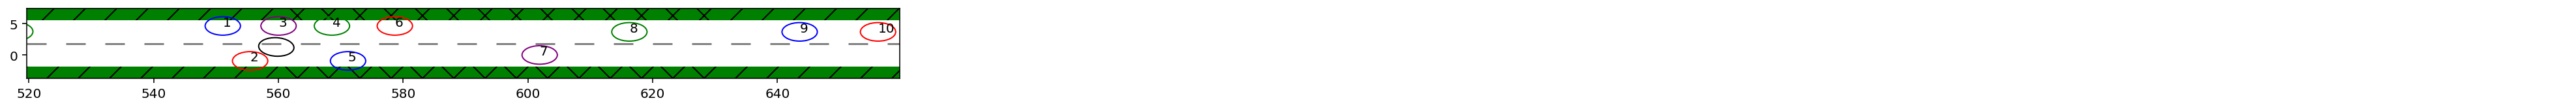

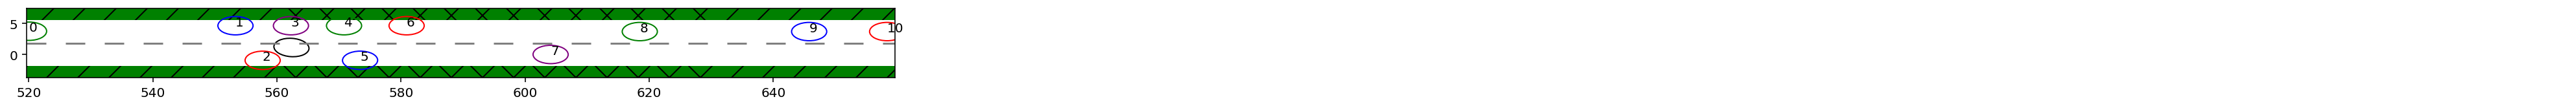

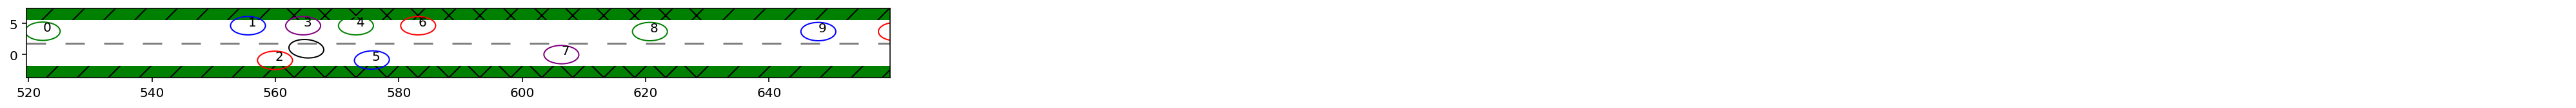

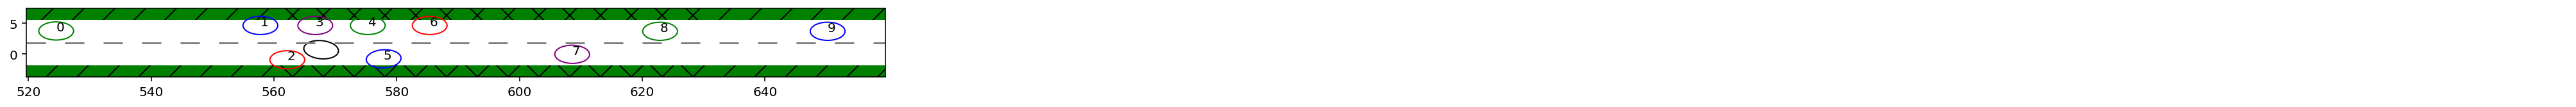

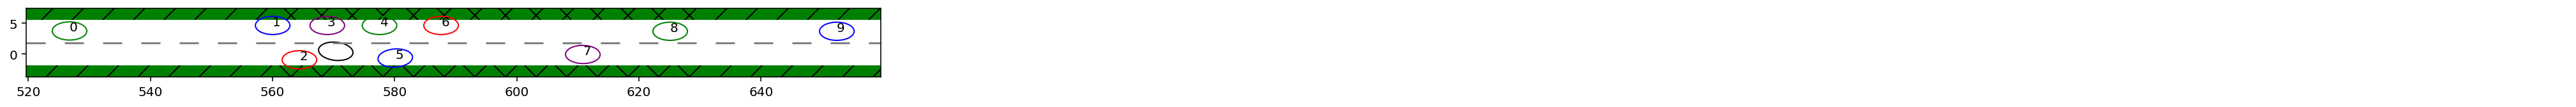

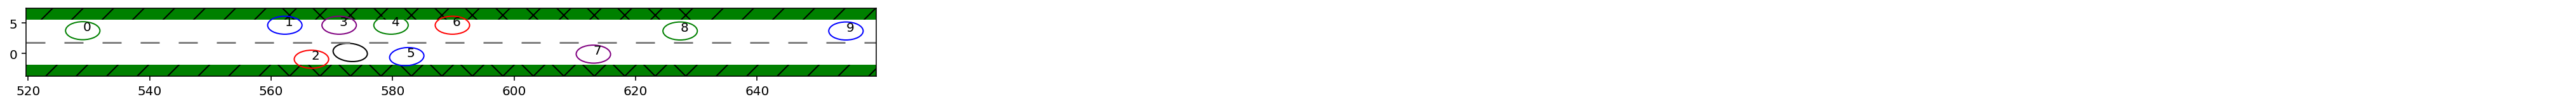

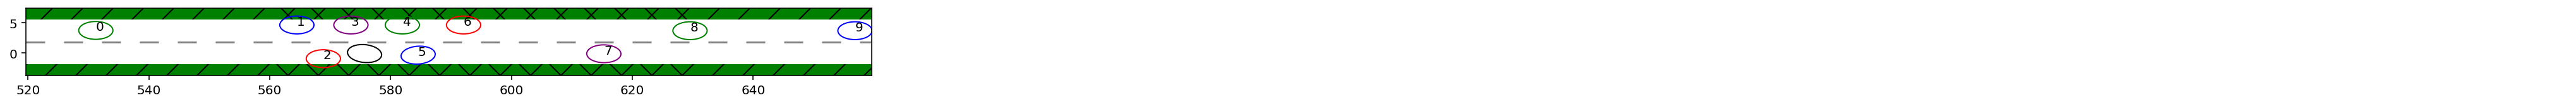

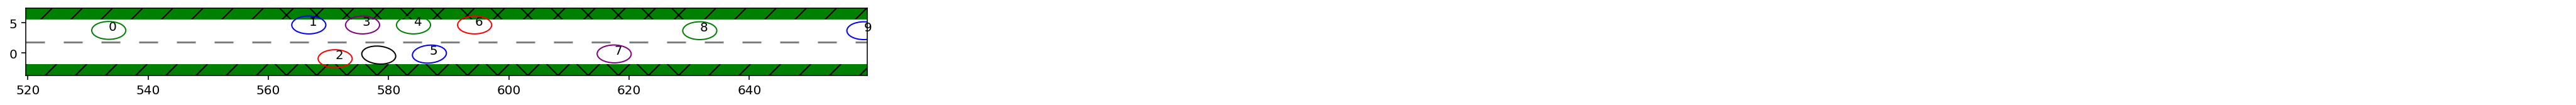

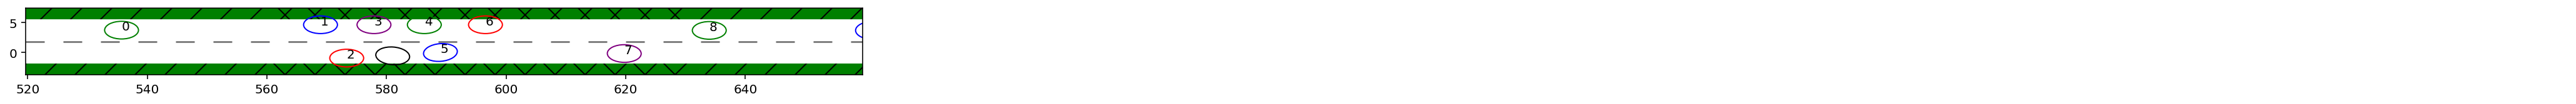

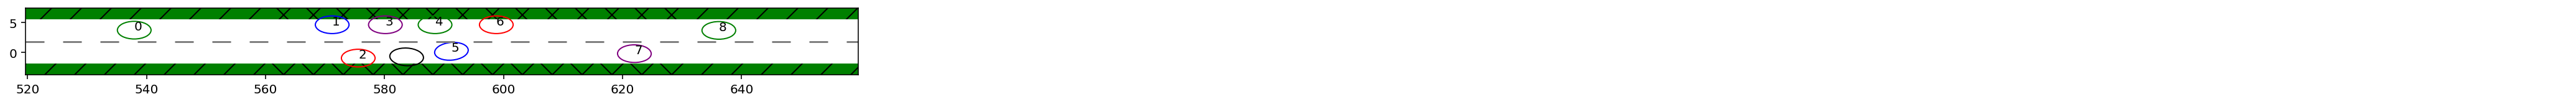

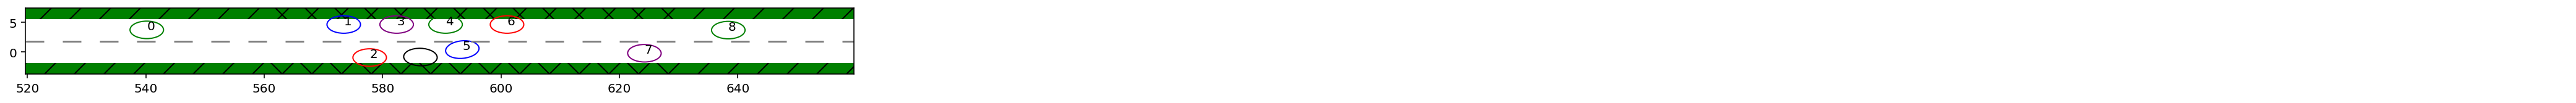

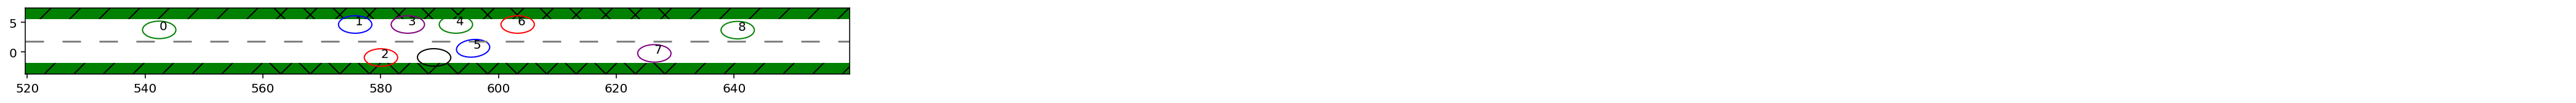

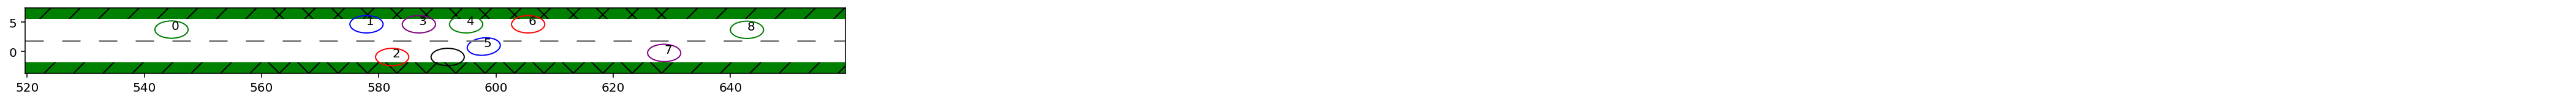

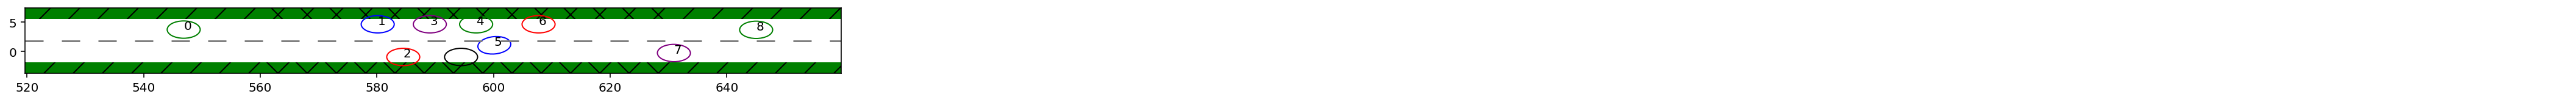

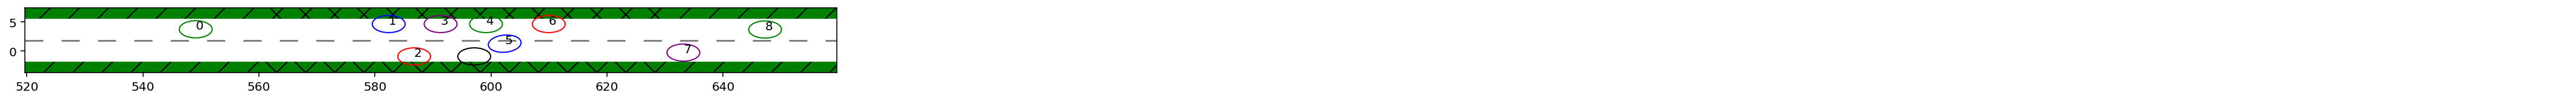

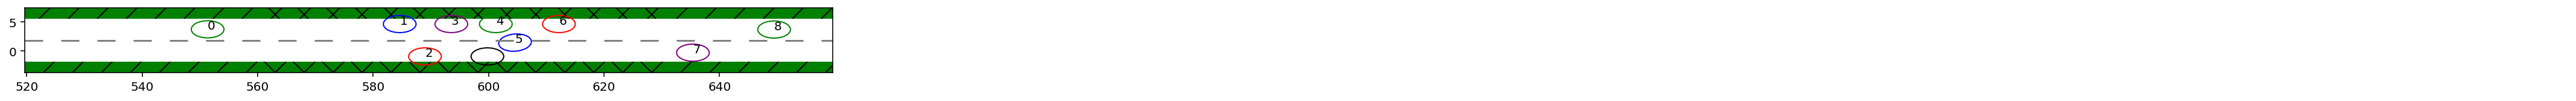

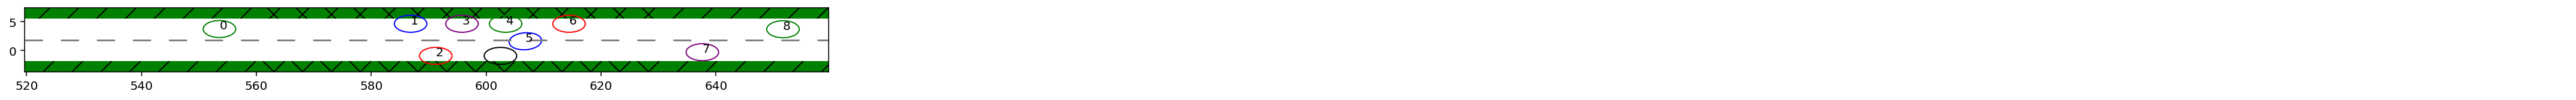

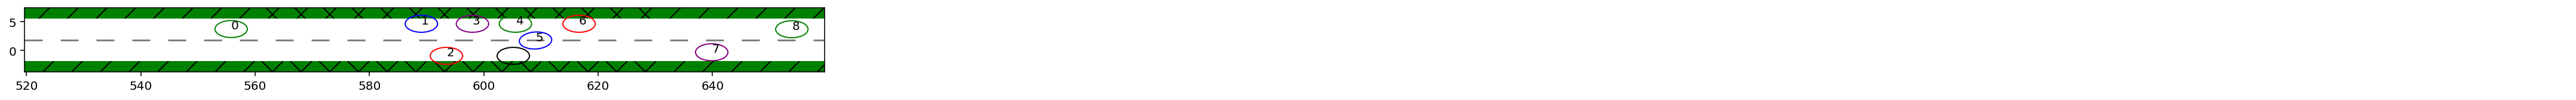

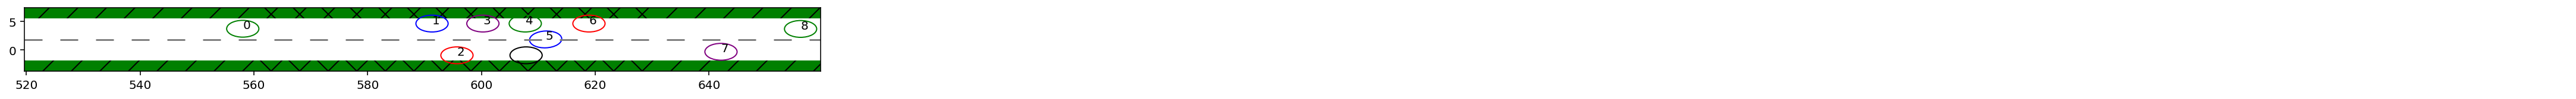

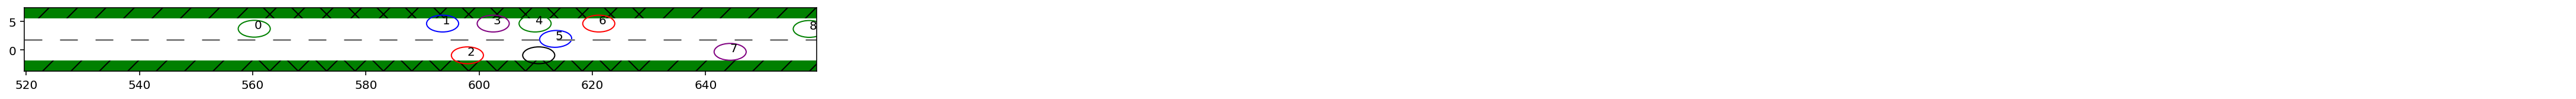

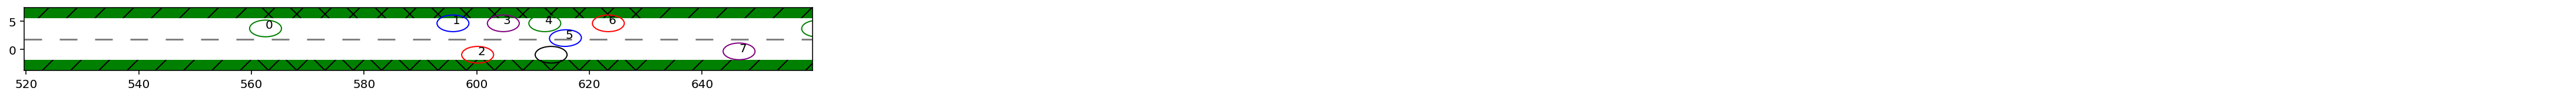

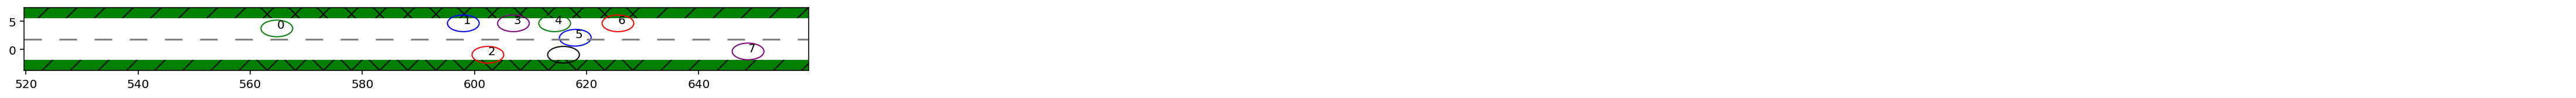

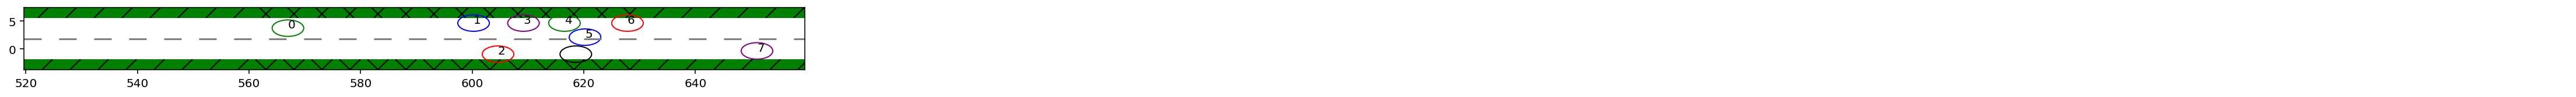

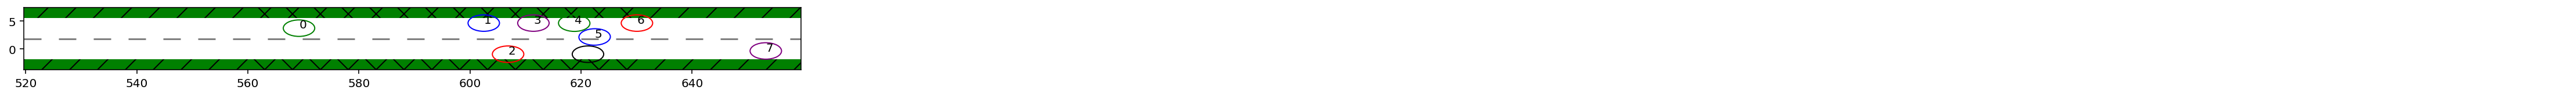

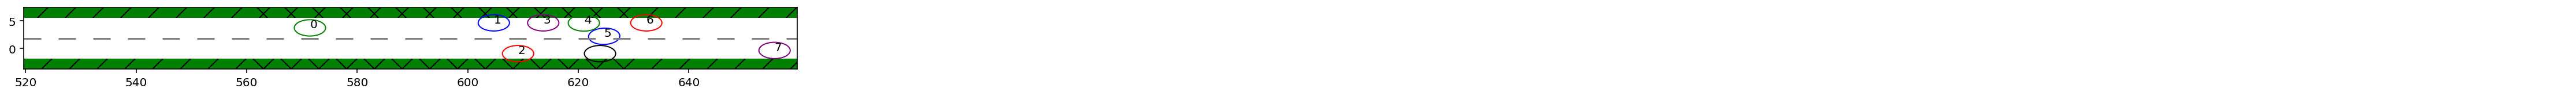

In [120]:
for k in range(params['N']):
    cmplot.plot_single_frame(world, response_vehicle, xamb_mpc, xothers_mpc, None, "ellipse", False, None, [k], car_ids = [-1] + [i for i in range(len(xothers_mpc))])
    plt.show()

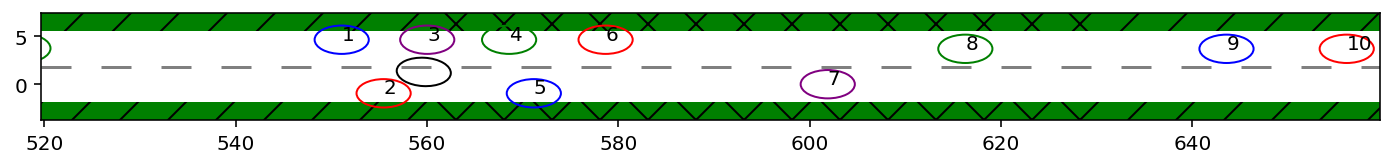

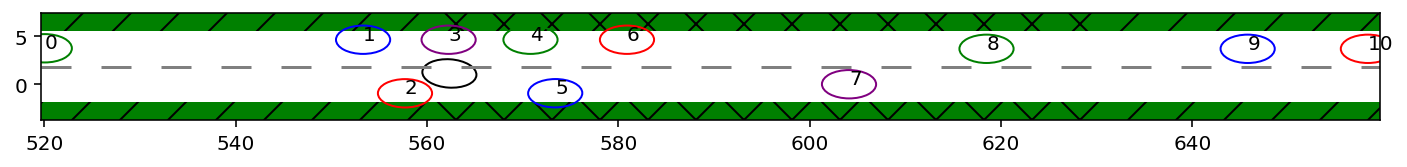

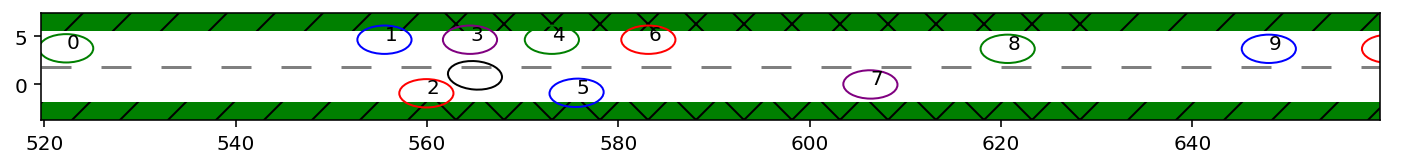

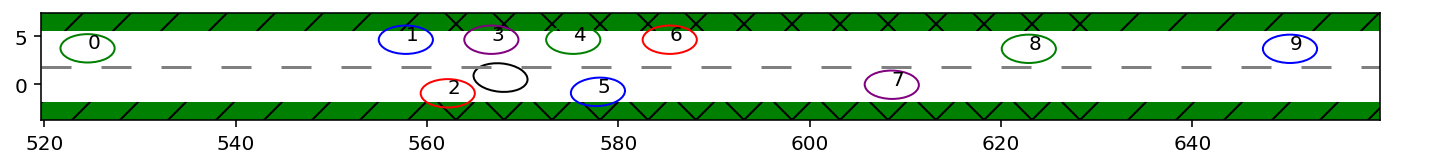

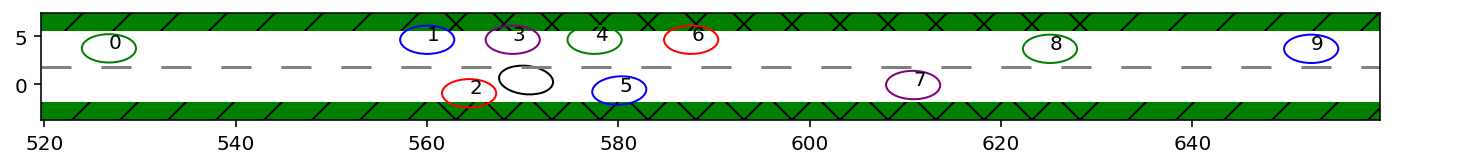

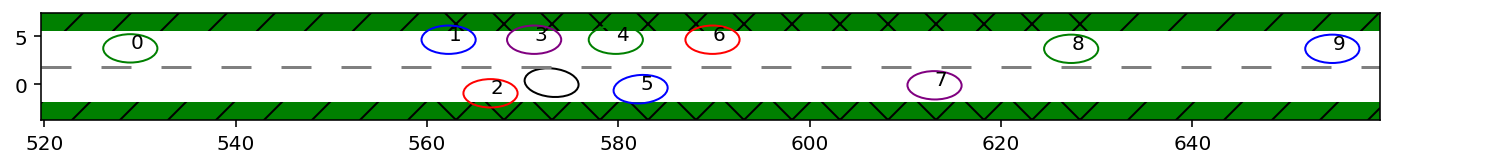

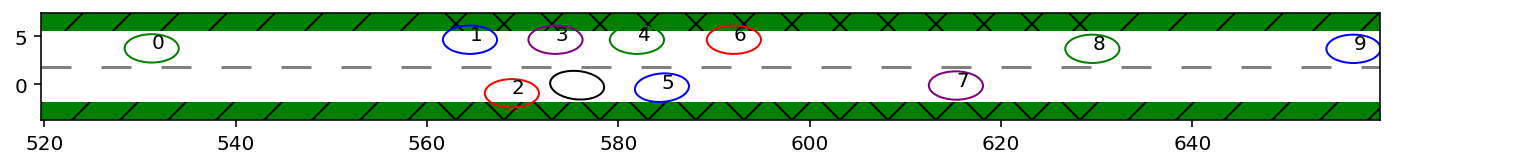

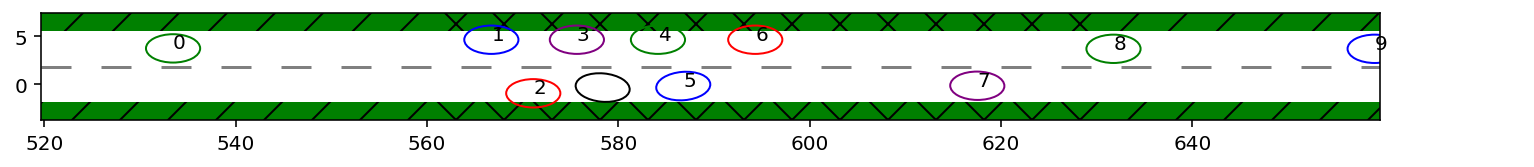

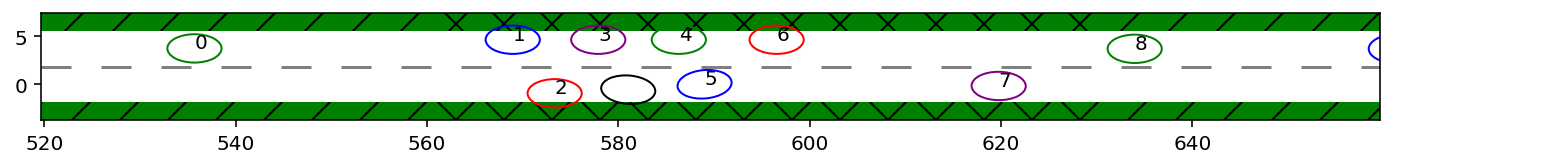

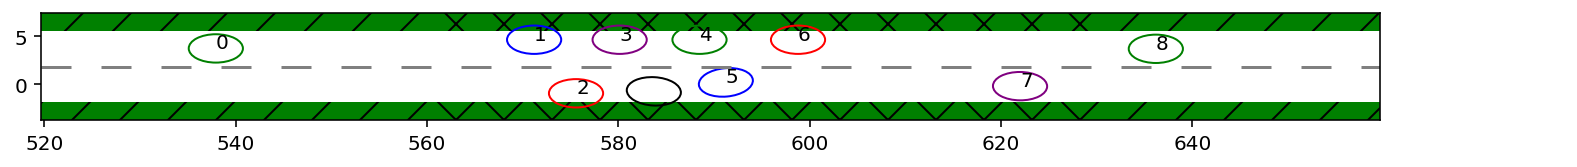

In [9]:
for k in range(params['number_ctrl_pts_executed']):
    cmplot.plot_single_frame(world, response_vehicle, xamb_mpc, xothers_mpc[:11], None, "ellipse", False, None, [k], car_ids = [-1] + [i for i in range(len(xothers_mpc[:11]))])

## Investigate the IBR

In [16]:
i_mpc = 21
i_rounds_ibr = 2
solve_number = 0
veh_id = -1

In [17]:
xamb_ibr, uamb_ibr, xamb_des_ibr, all_other_x_ibr, all_other_u_ibr, all_other_x_des_ibr = mpc.load_state(log_directory + "data/"+'ibr_m%03di%03damb'%(i_mpc, i_rounds_ibr), params['n_other'])

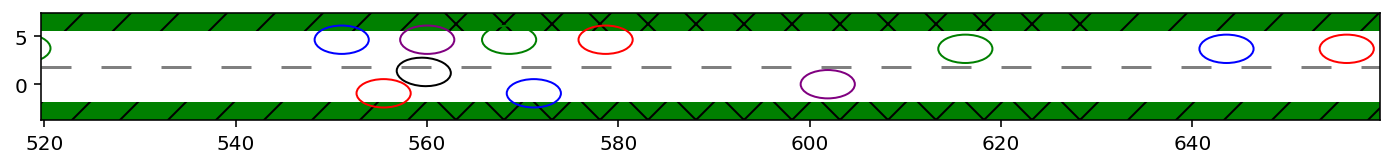

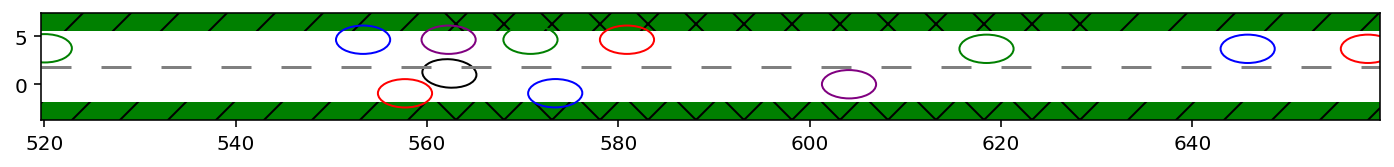

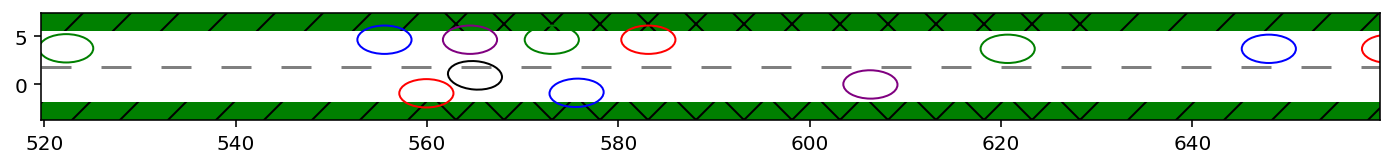

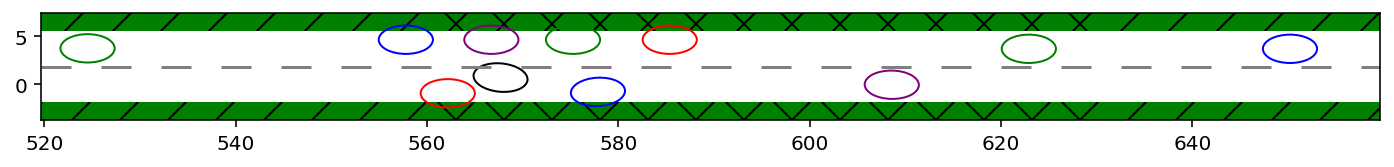

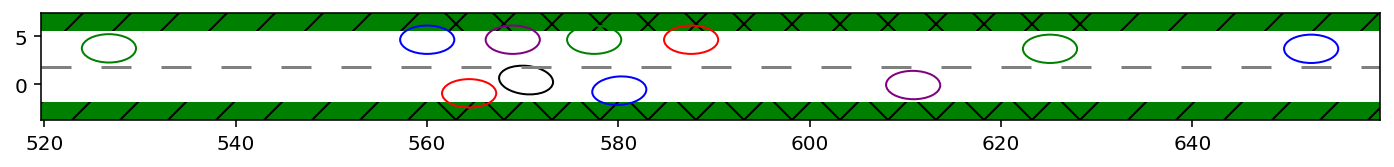

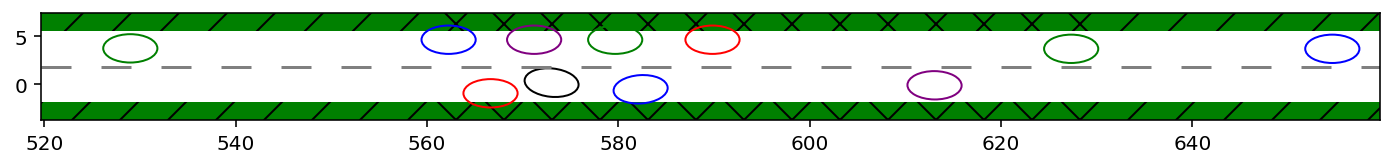

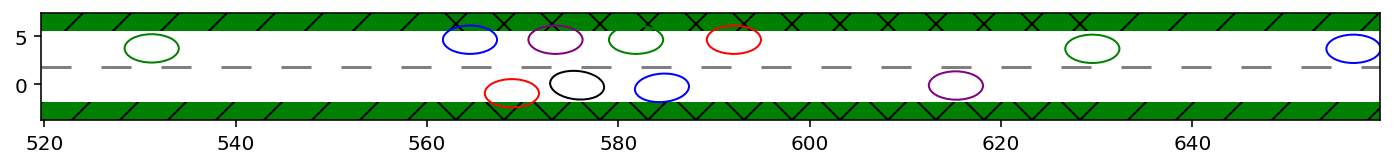

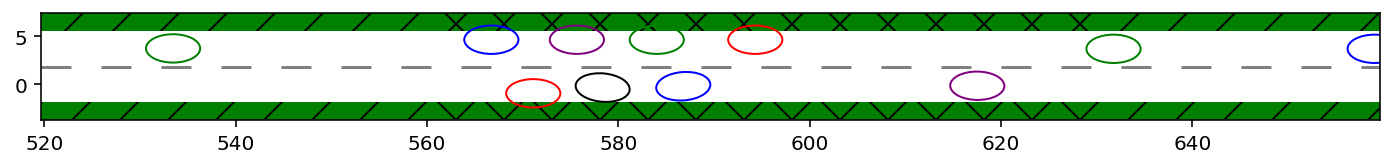

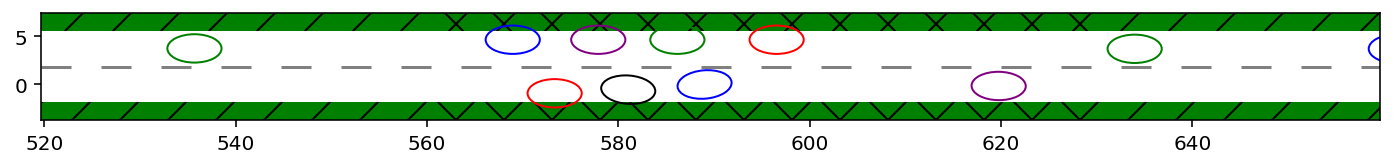

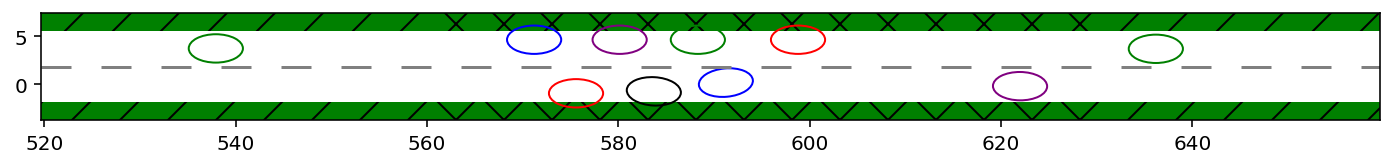

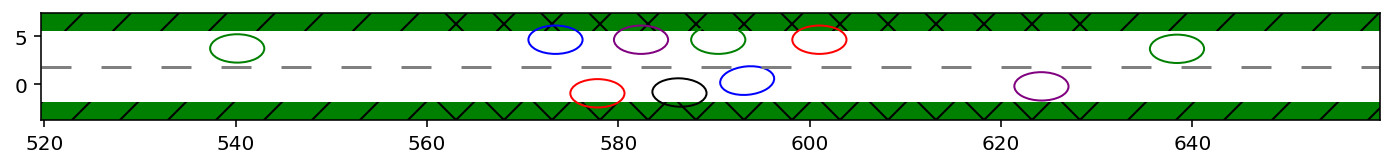

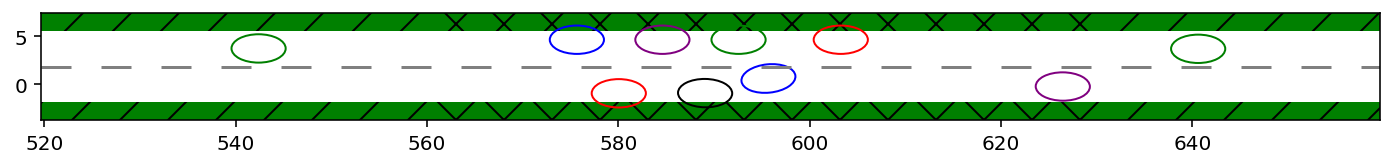

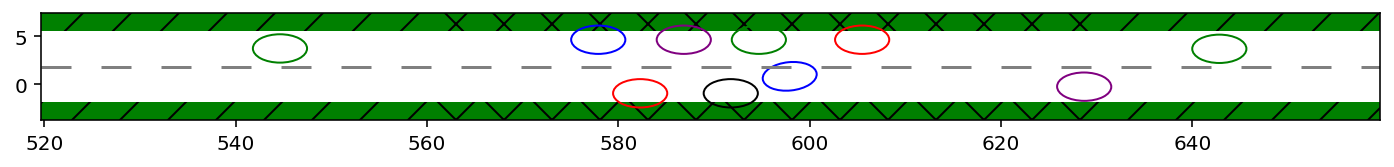

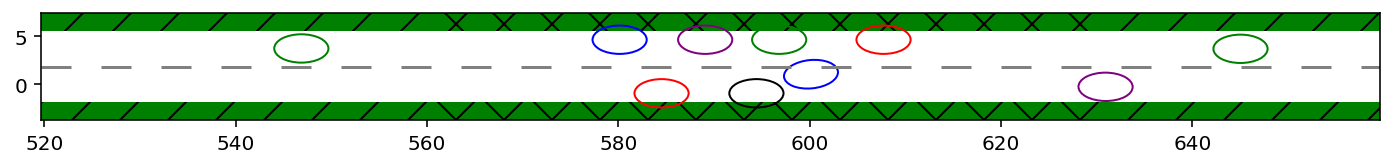

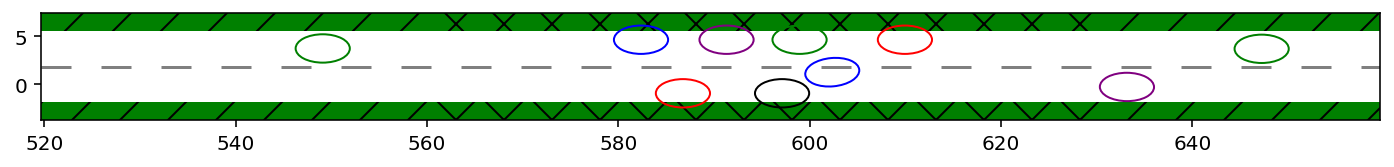

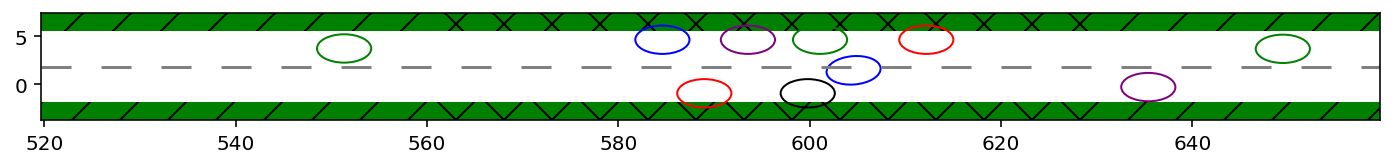

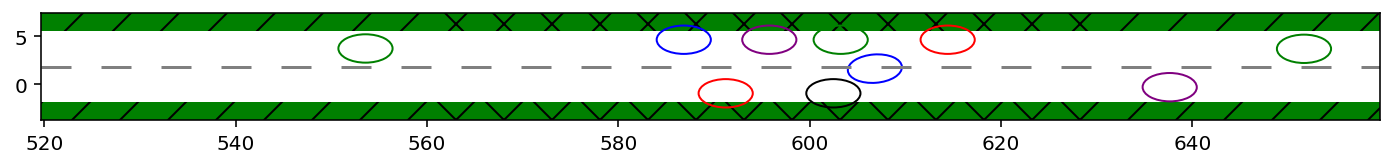

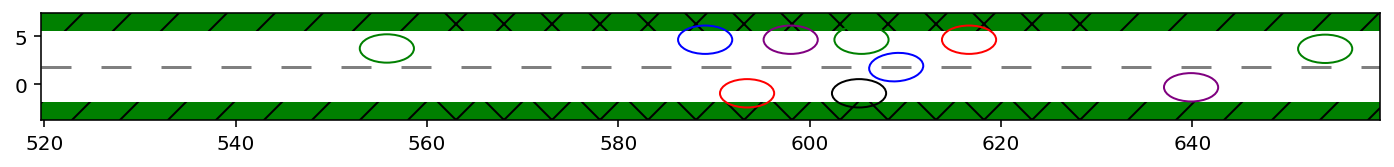

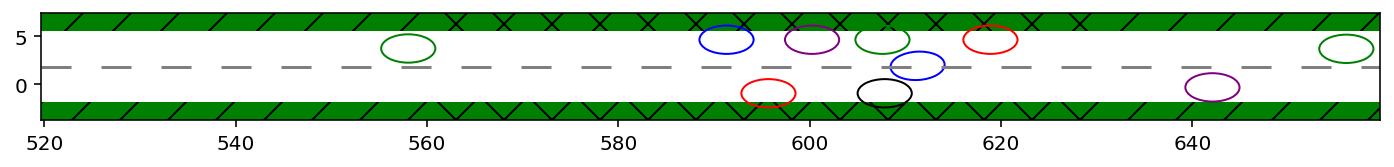

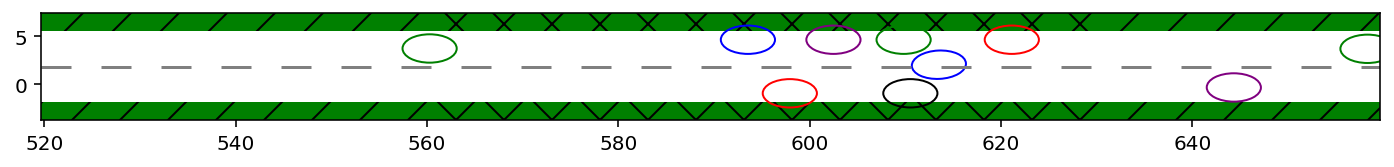

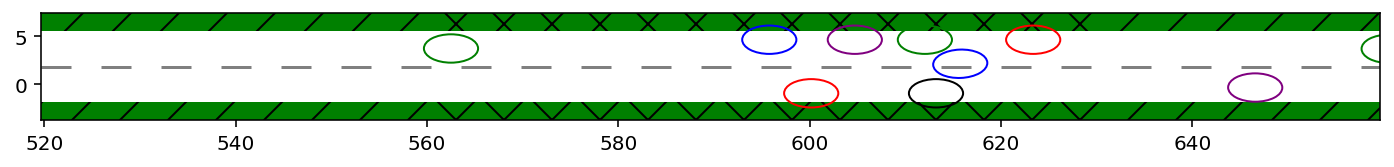

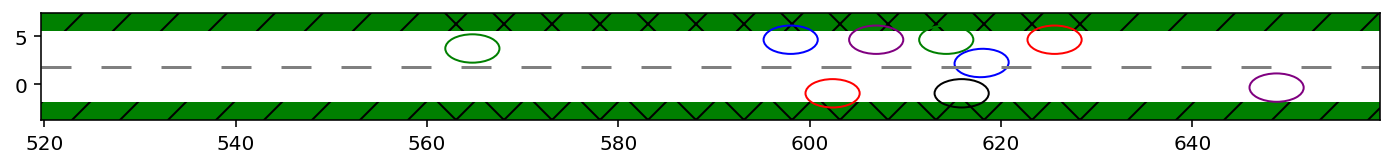

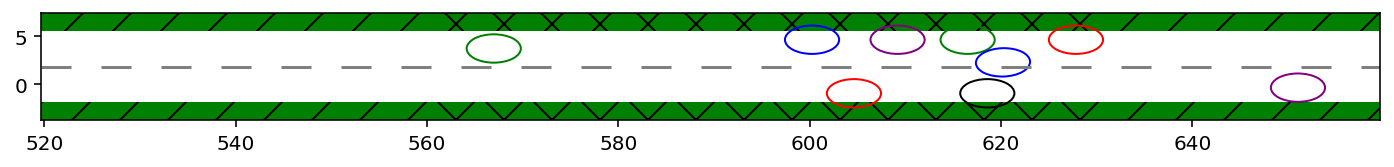

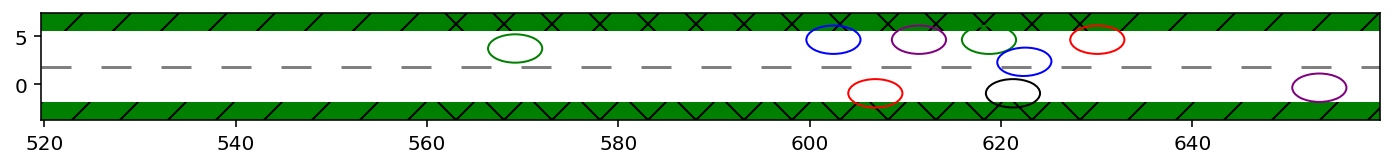

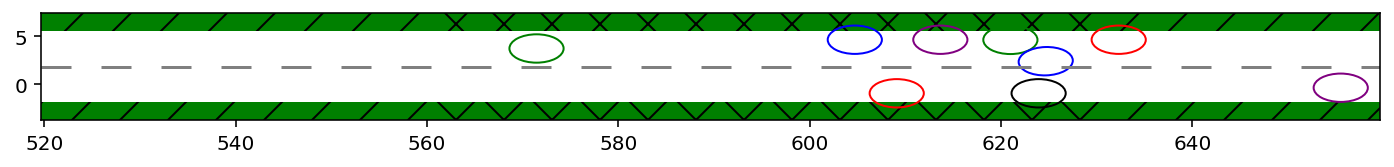

In [18]:
for k in range(params['N']):
    cmplot.plot_single_frame(world, response_vehicle, xamb_ibr, all_other_x_ibr, None, "ellipse", False, None, [k])

## Investigate Each Best Response

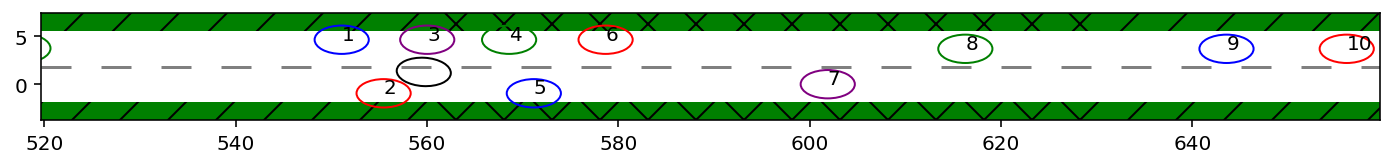

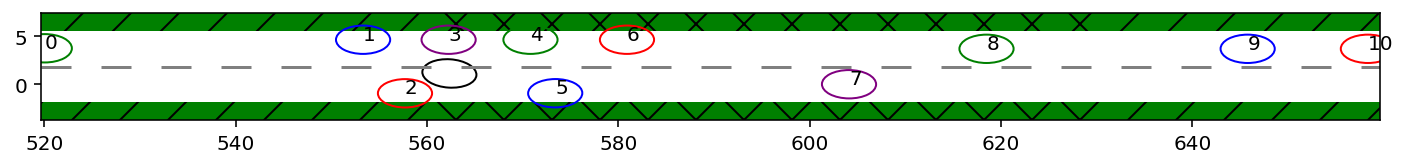

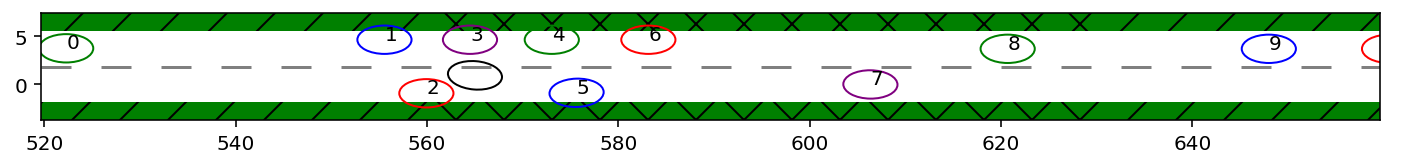

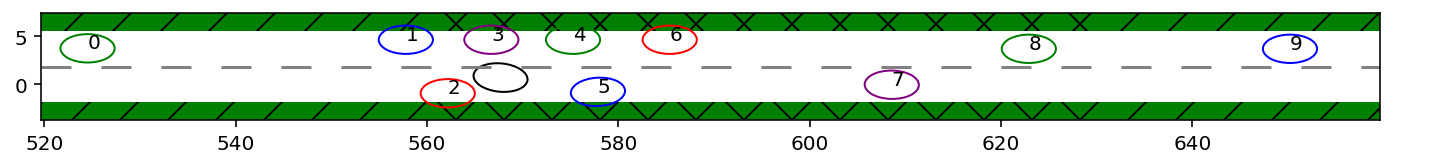

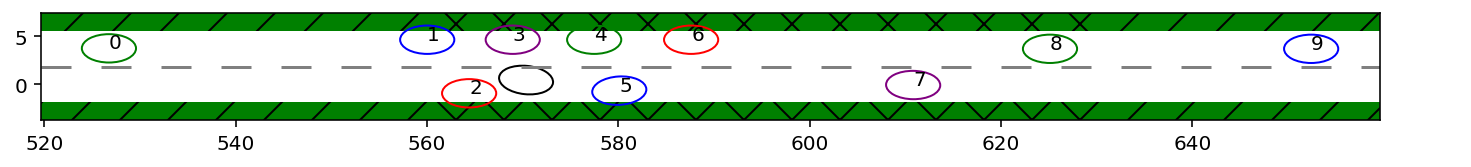

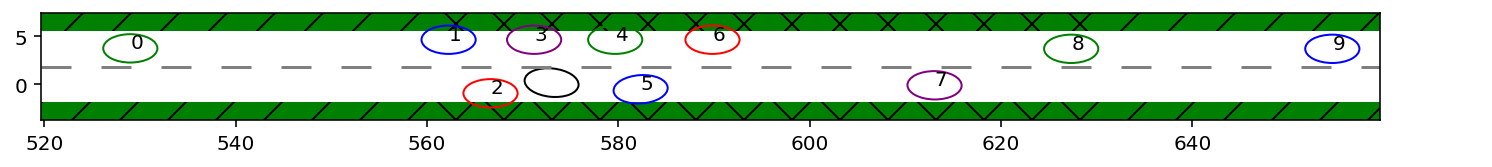

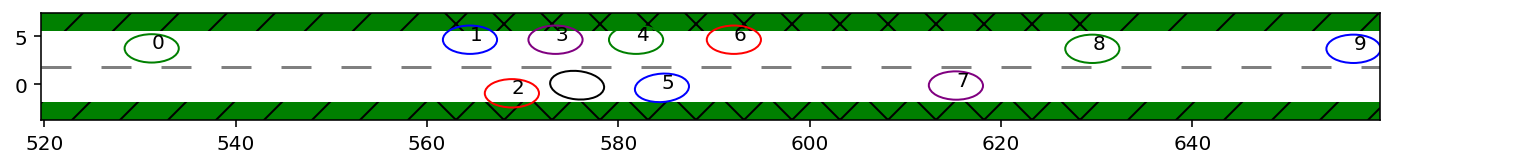

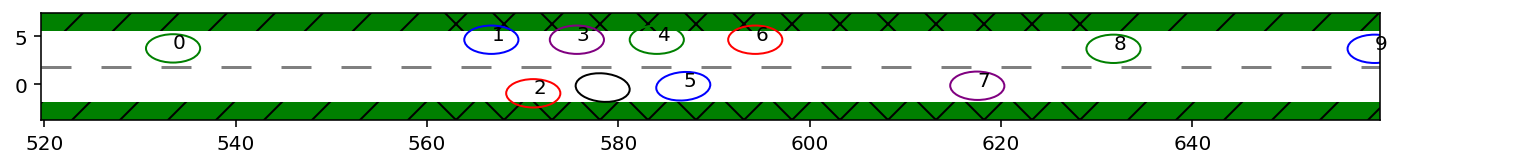

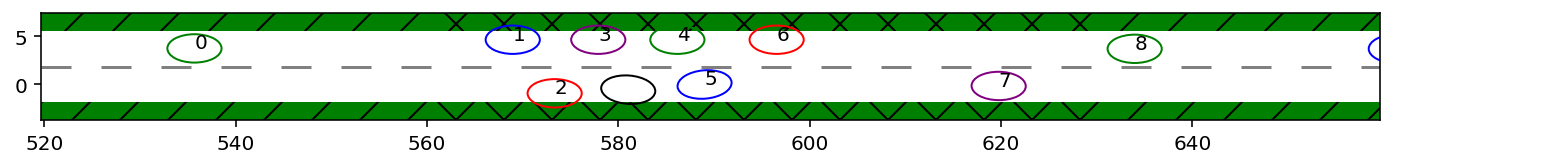

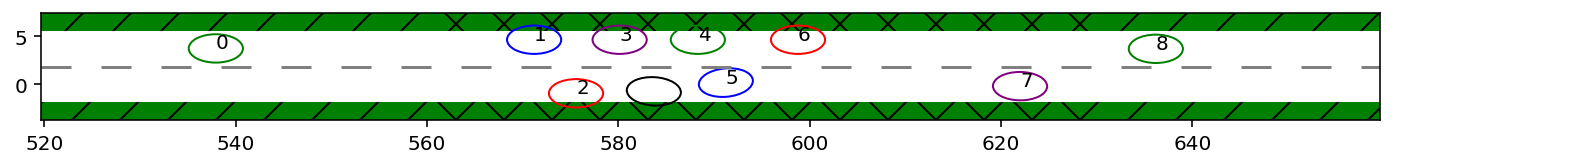

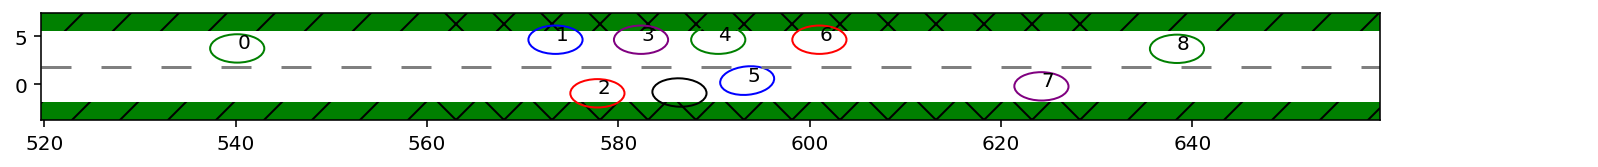

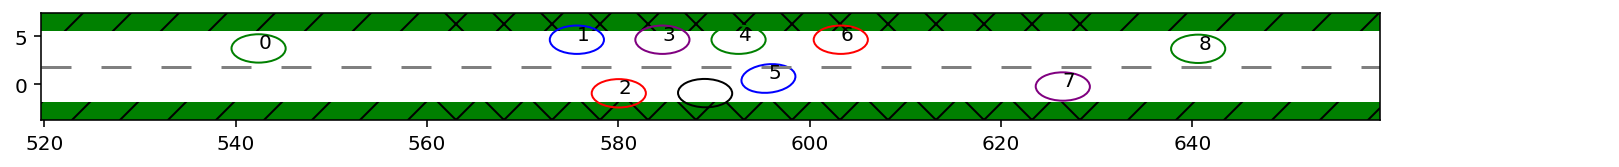

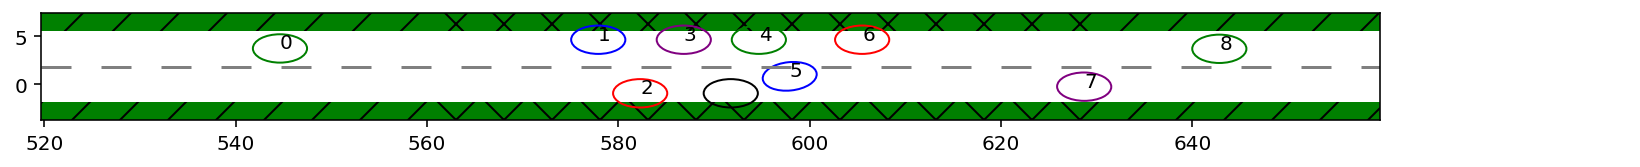

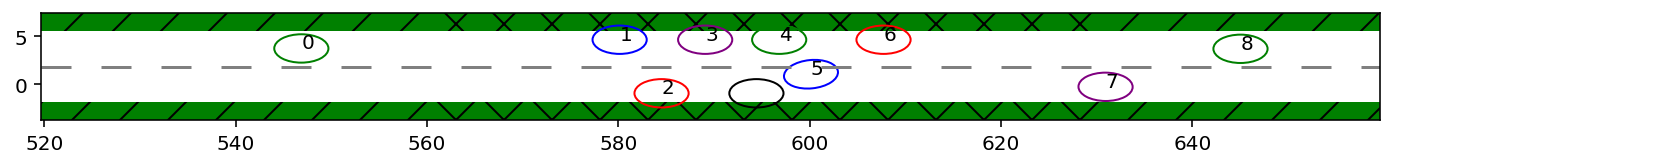

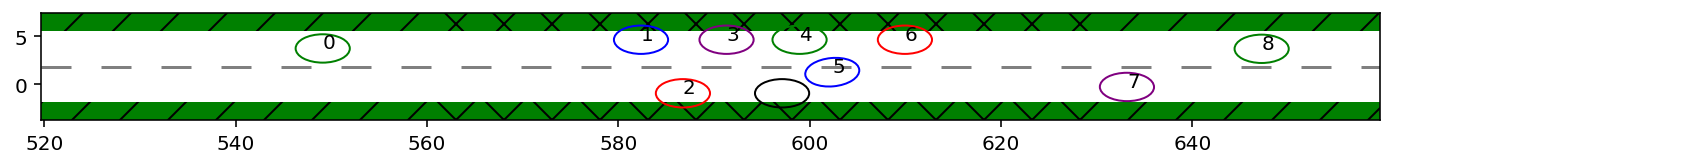

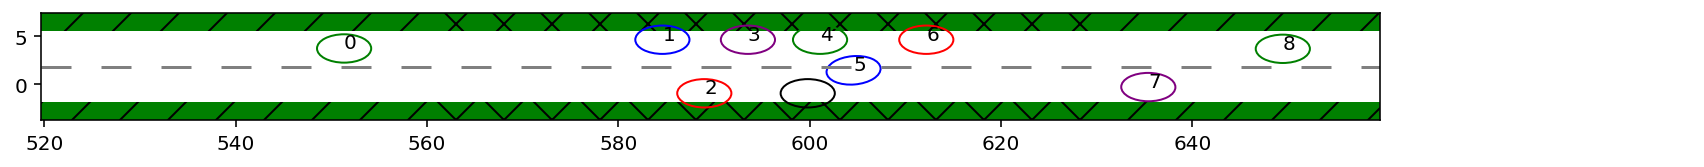

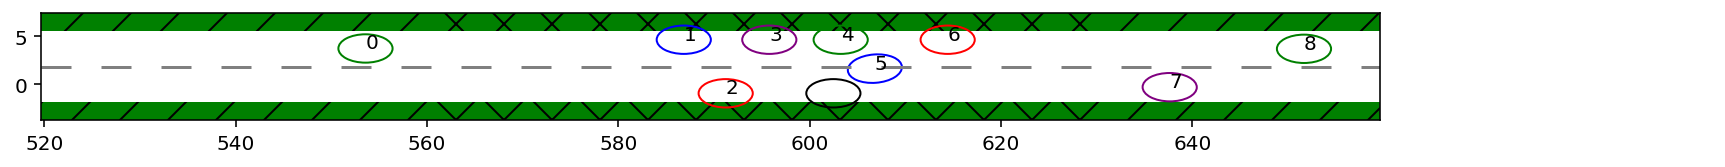

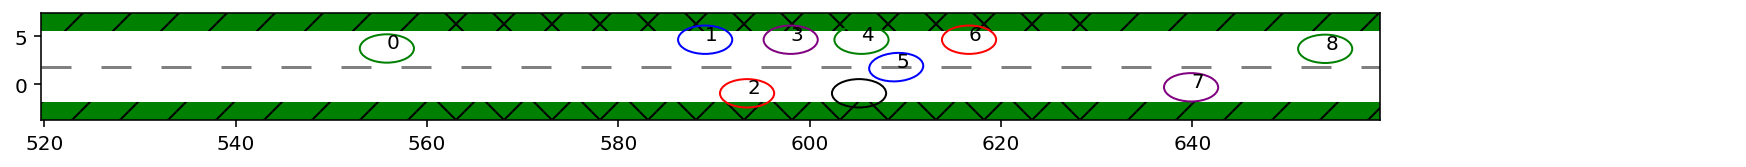

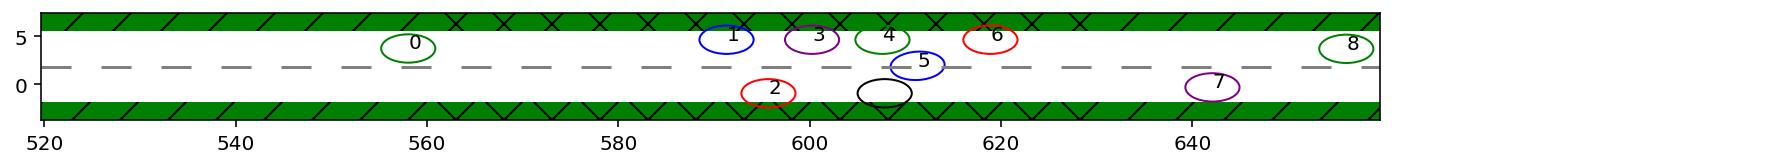

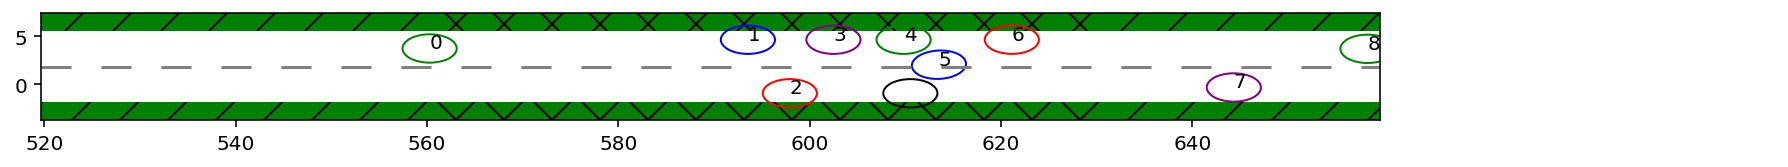

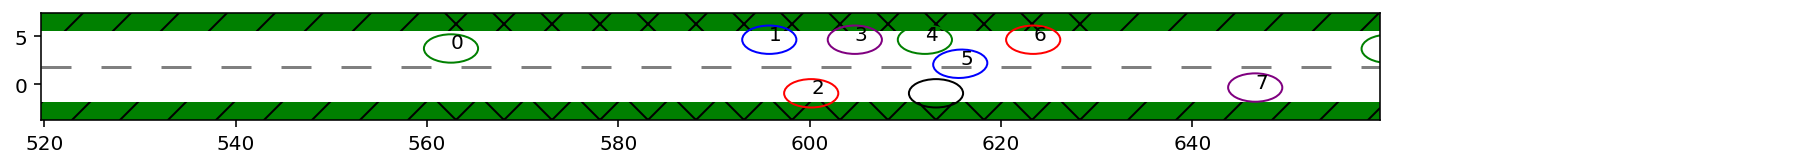

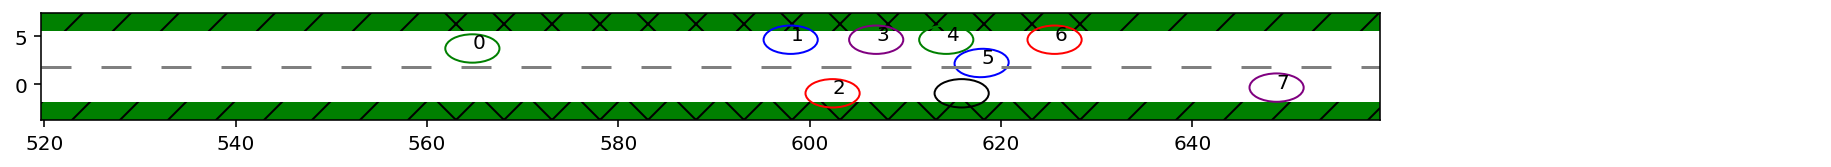

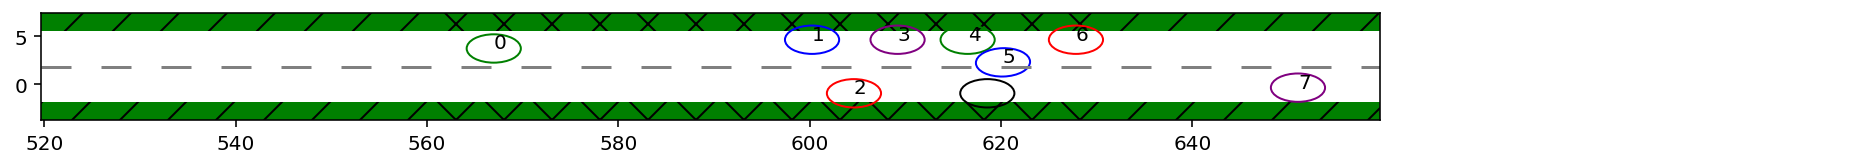

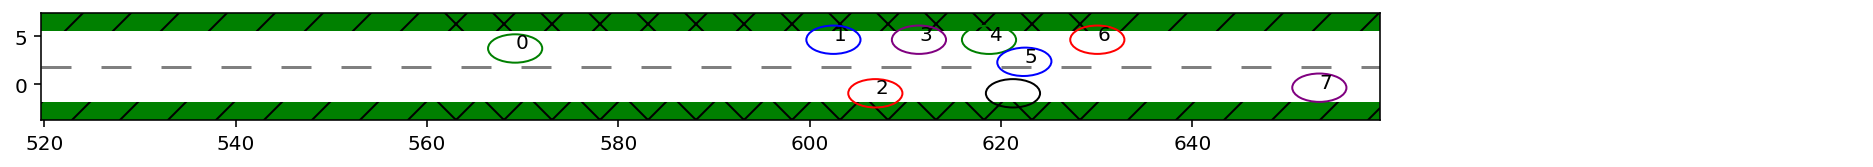

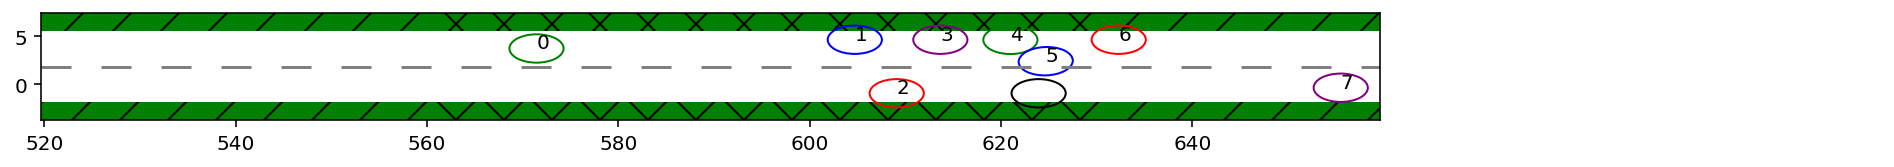

In [36]:
i_mpc = 21
i_rounds_ibr = 2
solve_number = 0
veh_id = 11
xamb_ibr, uamb_ibr, xamb_des_ibr, all_other_x_ibr, all_other_u_ibr, all_other_x_des_ibr = mpc.load_state(log_directory + "data/"+'ibr_m%03di%03damb'%(i_mpc, i_rounds_ibr), params['n_other'])
for k in range(params['N']):
    cmplot.plot_single_frame(world, response_vehicle, xamb_ibr, all_other_x_ibr[:11], None, "ellipse", False, None, [k], car_ids = [-1] + [i for i in range(len(all_other_x_ibr[:11]))])

In [121]:
number_ctrl_pts_executed = params["number_ctrl_pts_executed"]
amb_x0_g = cp.deepcopy(xamb_mpc[:, number_ctrl_pts_executed])
all_other_x0_g = [cp.deepcopy(xothers_mpc[i][:, number_ctrl_pts_executed]) for i in range(len(xothers_mpc))]
## Amb_x0 is localized in renference to ambulance
amb_x0 = cp.deepcopy(amb_x0_g)
amb_x0[0] -= amb_x0_g[0]
amb_x0[-1] = 0
all_other_x0 = cp.deepcopy(all_other_x0_g)
for j in range(len(all_other_x0_g)):
    all_other_x0[j][0] -= amb_x0_g[0]
    all_other_x0[j][-1] = 0

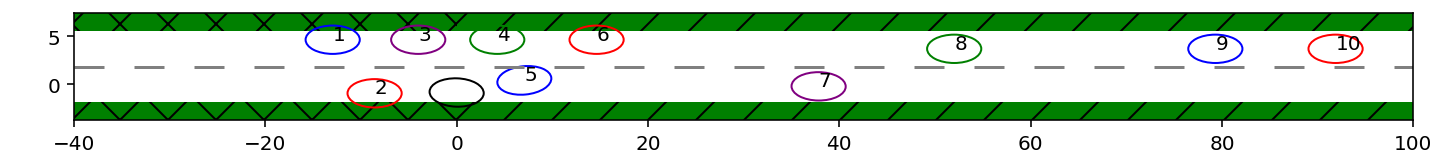

In [122]:
for k in range(1):
    cmplot.plot_single_frame(world, response_vehicle, amb_x0.reshape(6,1), [x.reshape(6,1) for x in all_other_x0[:11]], None, "ellipse", False, None, [k], car_ids = [-1] + [i for i in range(len(all_other_x_ibr[:11]))])

In [123]:
all_other_u_mpc = cp.deepcopy(uothers_mpc)
N = params["N"]
all_other_u_ibr, all_other_x_ibr, all_other_x_des_ibr = helper.extend_last_mpc_and_follow(all_other_u_mpc, number_ctrl_pts_executed, N, all_other_MPC, all_other_x0, params, world)  


Ambulance guess of ado...
...veh 000
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 696.00us ( 40.94us)   5.73ms (337.28us)        17
       nlp_g  |   2.34ms (137.65us)   2.34ms (137.55us)        17
    nlp_grad  | 446.00us (446.00us) 721.21us (721.21us)         1
  nlp_grad_f  | 819.00us ( 74.45us) 820.41us ( 74.58us)        11
  nlp_hess_l  |  21.86ms (  2.43ms)  71.65ms (  7.96ms)         9
   nlp_jac_g  |  10.09ms (917.27us)  20.20ms (  1.84ms)        11
       total  |  59.34ms ( 59.34ms) 129.39ms (129.39ms)         1
...veh 001
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 541.00us ( 41.62us) 542.78us ( 41.75us)        13
       nlp_g  |   1.65ms (126.69us)   1.64ms (126.33us)        13
    nlp_grad  | 322.00us (322.00us) 323.11us (323.11us)         1
  nlp_grad_f  | 854.00us ( 65.69us) 858.69us ( 66.05us)        13
  nlp_hess_l  |  21.49ms (  1.95ms)  37.39ms (  3.40ms)        11
   nlp_jac_g  |  10.14ms (78

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:999: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'NonIpopt_Exception_Thrown'

In [113]:
i = 4
print("...veh %03d"%i)
# Ctrl and traj from previous MPC
prev_ctrl = all_other_u_mpc[i][:, number_ctrl_pts_executed:-1] #take off the last position
prev_traj, prev_traj_des = all_other_MPC[i].forward_simulate_all(all_other_x0[i].reshape(6,1), prev_ctrl)
# Predicted portion of just lane following.  This is an estimated ctrl of ado vehicles.
initial_pt = prev_traj[:, -1]

...veh 004


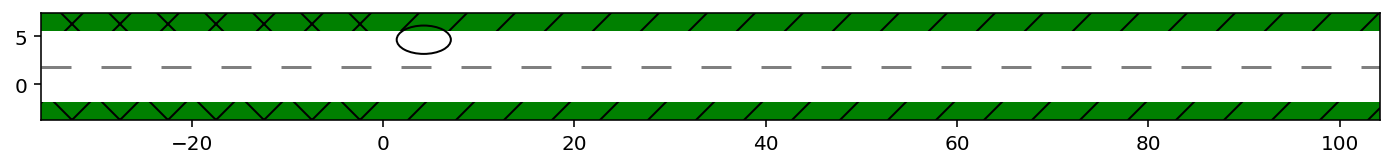

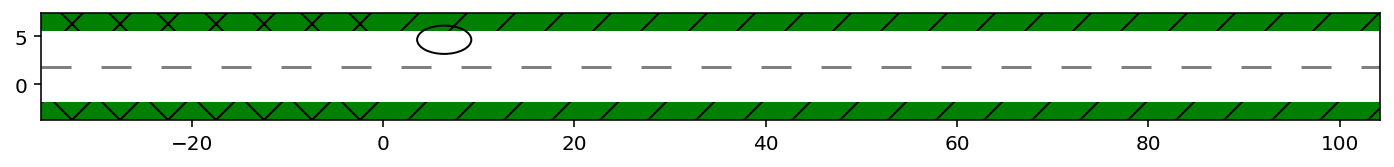

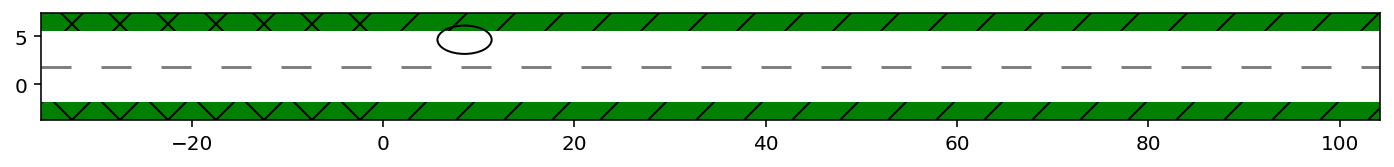

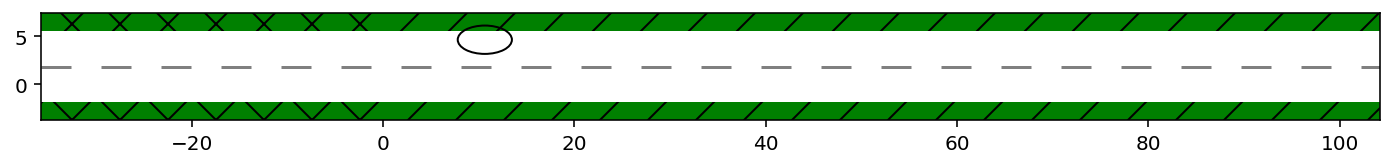

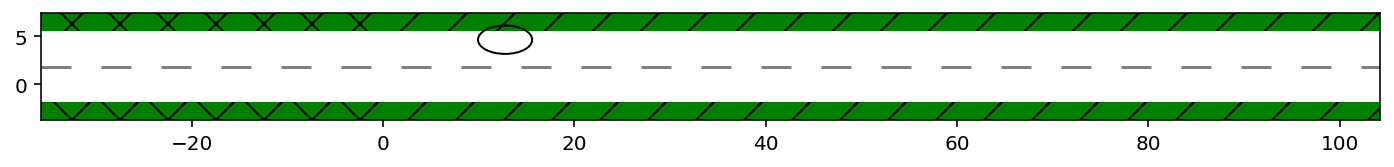

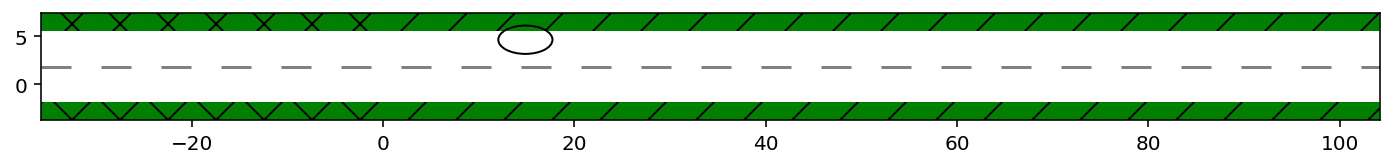

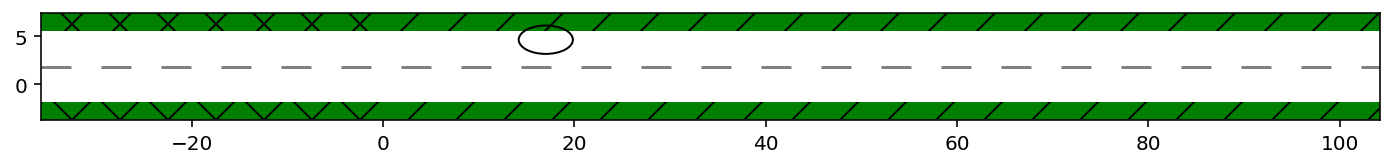

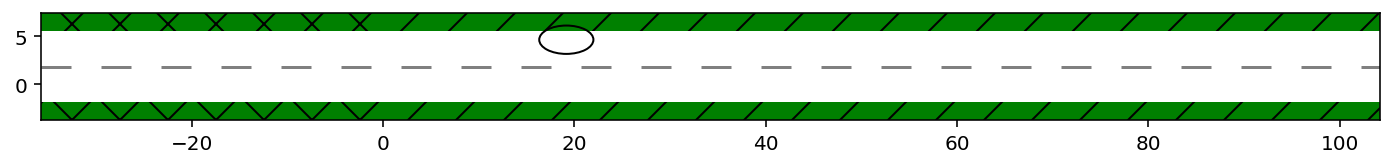

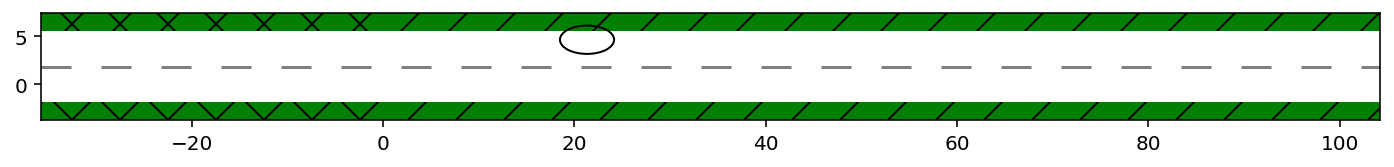

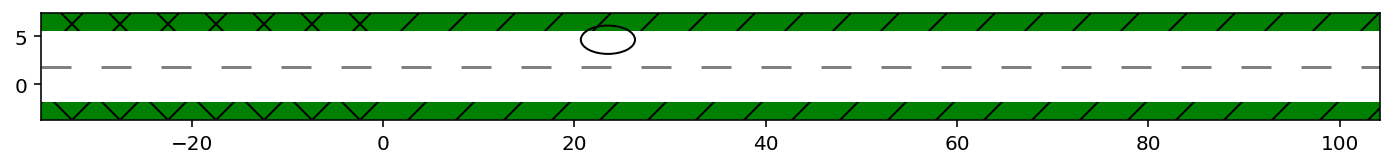

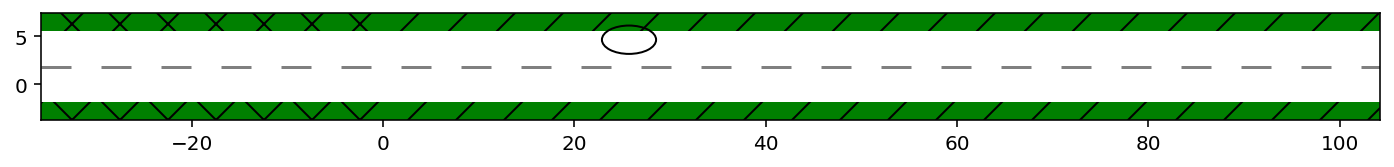

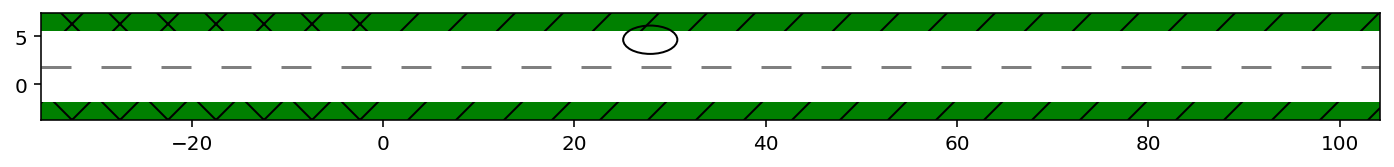

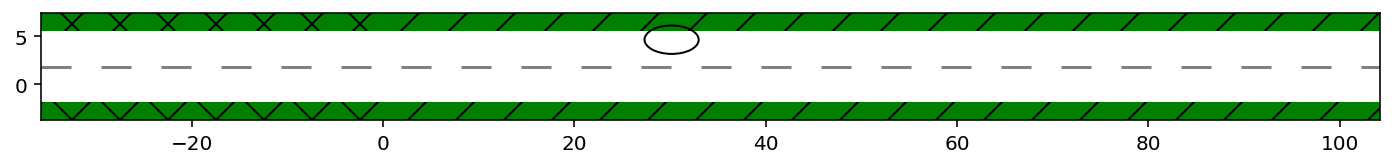

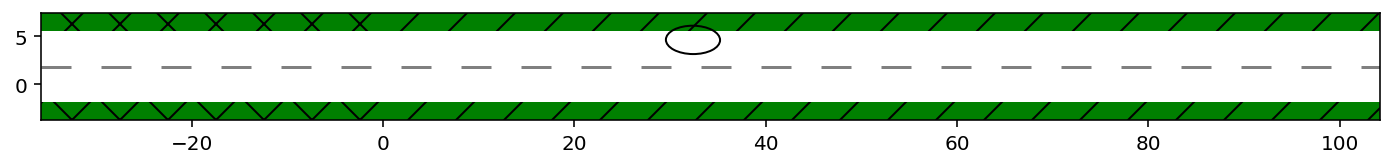

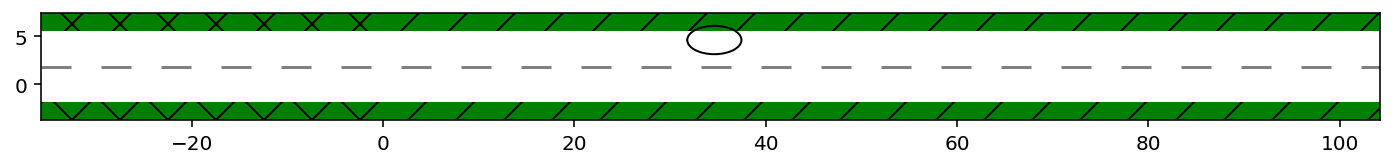

In [114]:
for k in range(prev_traj.shape[1]):
    cmplot.plot_single_frame(world, response_vehicle, prev_traj, [], None, "ellipse", False, None, [k])

In [115]:
lane_following_ctrl, lane_following_traj, lane_following_traj_des = helper.lane_following_optimizations(number_ctrl_pts_executed + 1, all_other_MPC[i], initial_pt, params, world)


      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   6.44ms ( 61.30us)   6.44ms ( 61.29us)       105
       nlp_g  |  17.37ms (165.40us)  61.78ms (588.39us)       105
    nlp_grad  | 604.00us (604.00us) 605.99us (605.99us)         1
  nlp_grad_f  |   7.29ms (137.60us)   7.28ms (137.27us)        53
  nlp_hess_l  | 137.65ms (  2.50ms) 293.52ms (  5.34ms)        55
   nlp_jac_g  |  76.70ms (  1.02ms) 175.73ms (  2.34ms)        75
       total  | 382.87ms (382.87ms) 760.05ms (760.05ms)         1


RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:999: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'

In [96]:
params

{'load_log_dir': None,
 'log_subdir': 'svo_10_19/p001',
 'mpc_start_iteration': 0,
 'save_solver_input': False,
 'T': 5,
 'dt': 0.2,
 'p_exec': 0.4,
 'car_density': 5000,
 'plot_flag': False,
 'print_flag': False,
 'n_other': 30,
 'n_mpc': 100,
 'n_ibr': 3,
 'n_processors': 15,
 'n_lanes': 2,
 'n_cntrld': 2,
 'rnds_shrd_cntrl': 2,
 'k_max_slack': 0.01,
 'k_solve_amb_max_ibr': 2,
 'k_max_solve_number': 3,
 'k_max_round_with_slack': inf,
 'k_slack_d': 1000,
 'k_CA_d': 0.05,
 'k_CA_power': 1.0,
 'wall_CA': False,
 'default_n_warm_starts': 15,
 'random_svo': 0,
 'svo_theta': 0.785398,
 'plan_fake_ambulance': False,
 'default_positions': False,
 'save_ibr': 1,
 'print_level': 0,
 'start_time_string': '20201019-213002',
 'N': 25,
 'number_ctrl_pts_executed': 10,
 'save_flag': True,
 'pid': 3805590}

In [116]:
N = number_ctrl_pts_executed + 1
response_MPC = all_other_MPC[i]
response_x0 = initial_pt
print(response_x0)
cp_MPC = cp.deepcopy(response_MPC)
# cp_MPC.max_delta_u = .5
cp_MPC.strict_wall_constraint = False
bri = mpc.MultiMPC(cp_MPC, [], [], world)
bri.generate_optimization(N, N*params["dt"], response_x0, [], [], slack=True, solve_amb=False, params = params, ipopt_params={'print_level':0})

bri.opti.subject_to(bri.u_opt[1,:] == 0)
bri.opti.set_initial(bri.x_opt, np.repeat(response_x0.reshape(6,1), N+1, axis=1))
bri.solution = bri.opti.solve()
x, u, x_des, _, _, _, _, _, _ = bri.get_solution()

[3.46221e+01 4.61995e+00 1.00845e-03 3.83970e-02 1.11750e+01 3.03775e+01]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 696.00us ( 58.00us) 695.68us ( 57.97us)        12
       nlp_g  |   1.68ms (139.58us)   1.67ms (139.05us)        12
    nlp_grad  | 602.00us (602.00us) 603.49us (603.49us)         1
  nlp_grad_f  |   1.28ms ( 98.23us)   1.28ms ( 98.48us)        13
  nlp_hess_l  |  22.85ms (  2.08ms)  23.13ms (  2.10ms)        11
   nlp_jac_g  |  11.05ms (849.92us)  11.14ms (857.16us)        13
       total  |  56.27ms ( 56.27ms)  56.56ms ( 56.56ms)         1


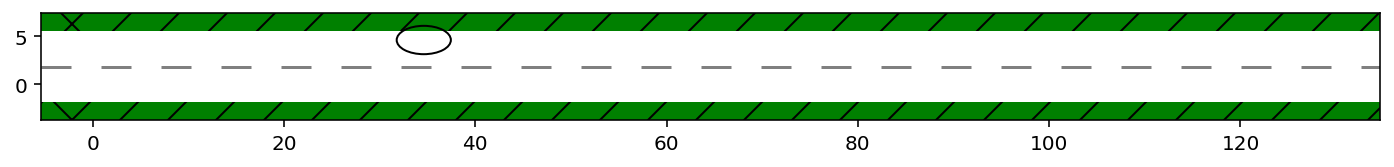

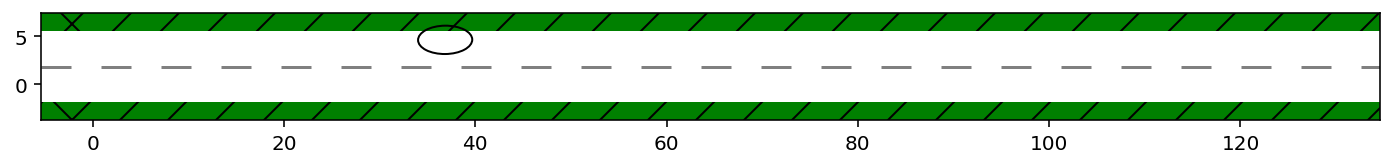

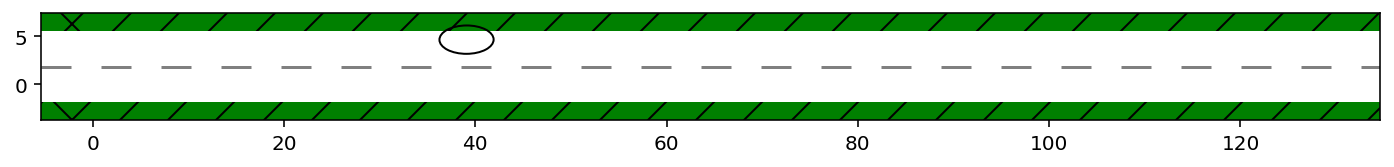

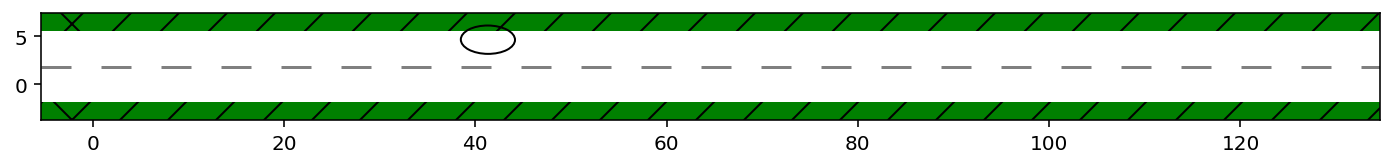

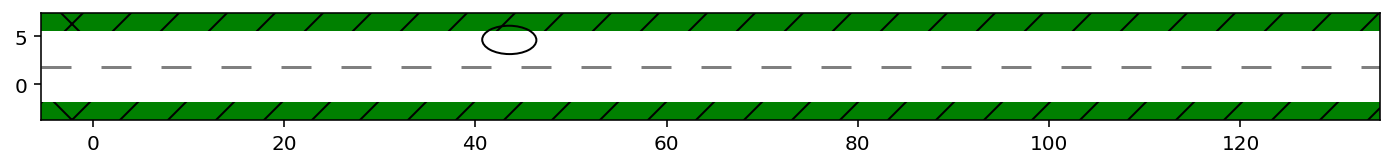

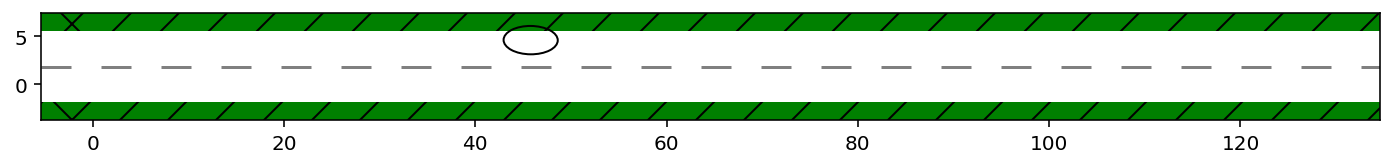

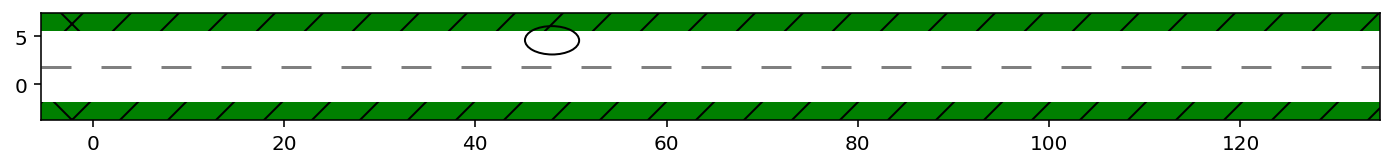

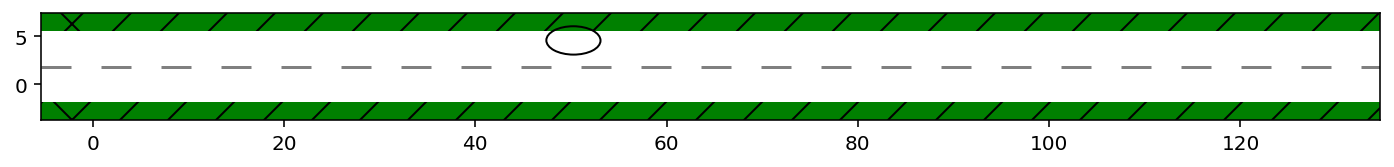

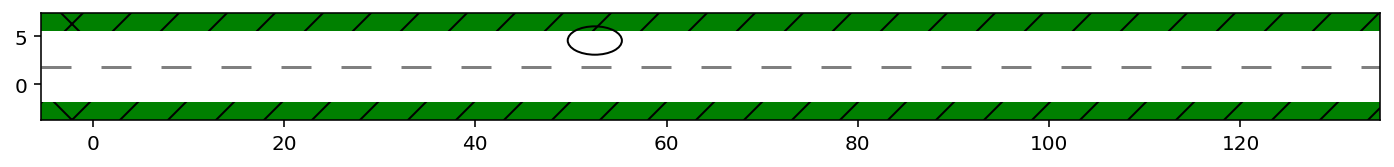

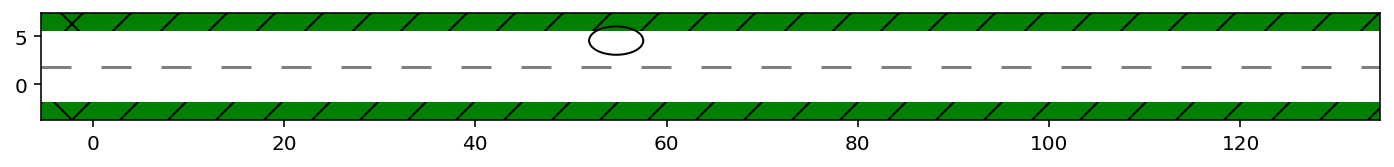

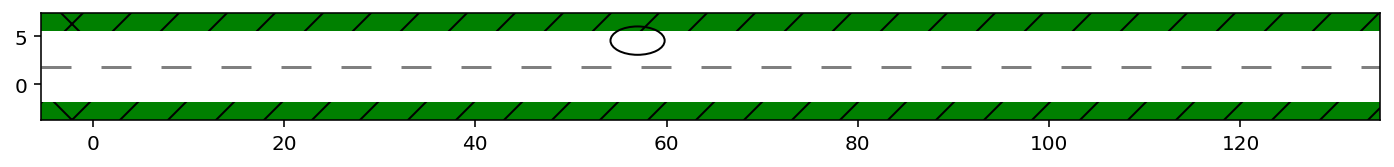

In [104]:
xnone, xdnone = cp_MPC.forward_simulate_all(response_x0, np.zeros((2,2)))
for k in range(x.shape[1]):
    cmplot.plot_single_frame(world, response_vehicle, x, [], None, "ellipse", False, None, [k])

In [101]:
x[1,:]

array([4.61995, 4.63707, 4.65856])

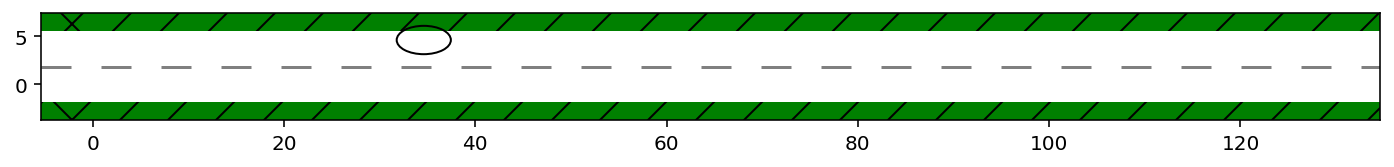

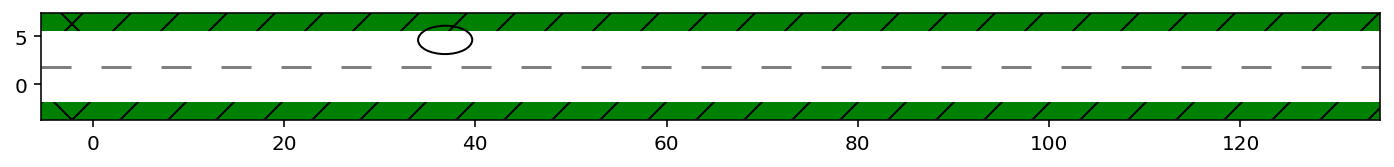

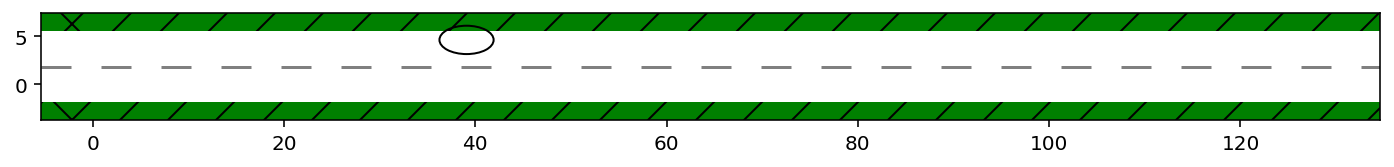

In [91]:
xs, xd = cp_MPC.forward_simulate_all(response_x0, u)
for k in range(xs.shape[1]):
    cmplot.plot_single_frame(world, response_vehicle, xs, [], None, "ellipse", False, None, [k])

In [79]:
bri.opti.debug.show_infeasibilities()

Violated constraints (tol 0), in order of declaration:
------- i = 0/48 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/vehicle.py:212 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At nonzero 0.
------- i = 1/48 ------ 
0 <= -4.28102e-13 <= 0 (viol 4.28102e-13)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/vehicle.py:212 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At nonzero 1.
------- i = 2/48 ------ 
0 <= -1.21211e-12 <= 0 (viol 1.21211e-12)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/vehicle.py:212 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At nonzero 2.
------

In [63]:
print(initial_pt)

[3.46221e+01 4.61995e+00 1.00845e-03 3.83970e-02 1.11750e+01 3.03775e+01]


In [50]:

# Lane following traj's initial pt is redundant (since it is also in prev traj)
lane_following_traj = lane_following_traj[:, 1:]
lane_following_traj_des = lane_following_traj_des[:, 1:]
all_other_u_ibr[i] = np.concatenate((prev_ctrl, lane_following_ctrl), axis=1)
all_other_x_ibr[i] = np.concatenate((prev_traj, lane_following_traj), axis=1)
all_other_x_des_ibr[i] = np.concatenate((prev_traj_des, lane_following_traj_des), axis=1)



      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.58ms ( 43.58us)   4.58ms ( 43.63us)       105
       nlp_g  |  11.92ms (113.52us)  11.89ms (113.24us)       105
    nlp_grad  | 297.00us (297.00us) 298.25us (298.25us)         1
  nlp_grad_f  |   4.15ms ( 78.21us)   4.14ms ( 78.18us)        53
  nlp_hess_l  | 116.32ms (  2.11ms) 221.32ms (  4.02ms)        55
   nlp_jac_g  |  60.56ms (807.49us)  89.29ms (  1.19ms)        75
       total  | 322.12ms (322.12ms) 455.01ms (455.01ms)         1


RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:999: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'

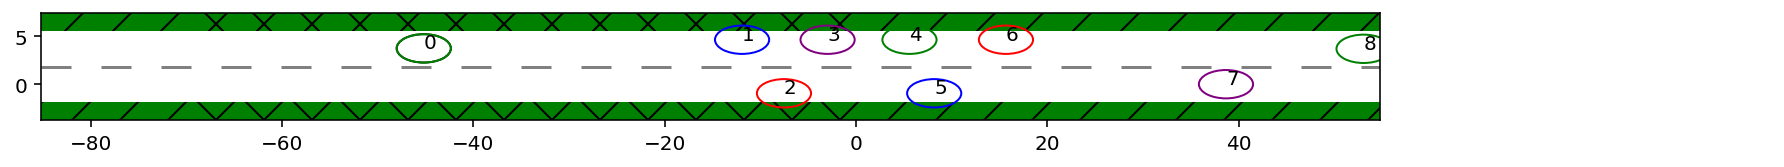

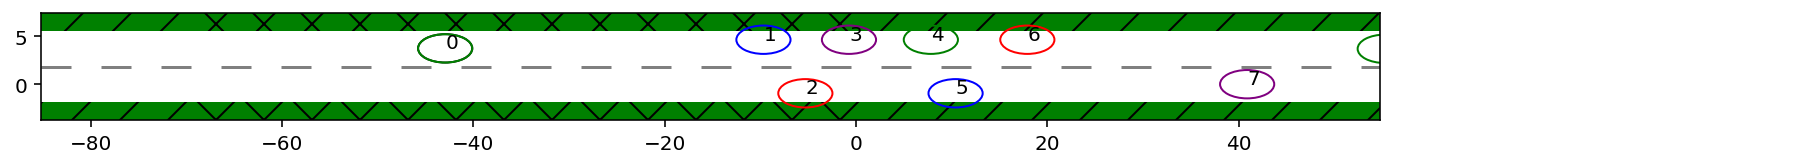

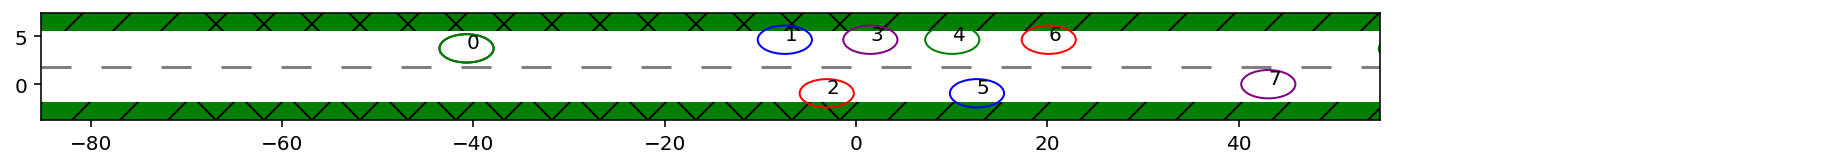

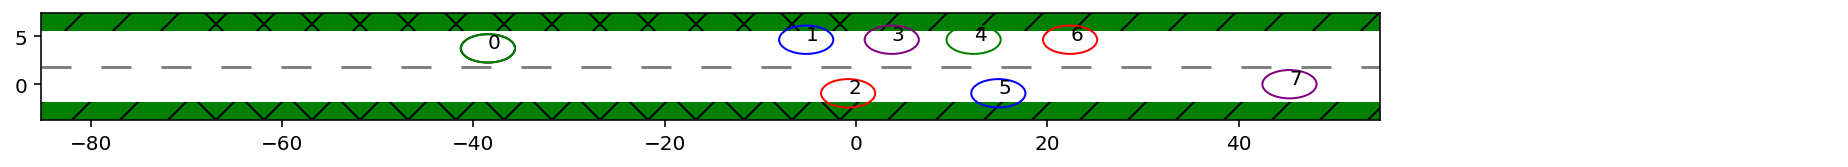

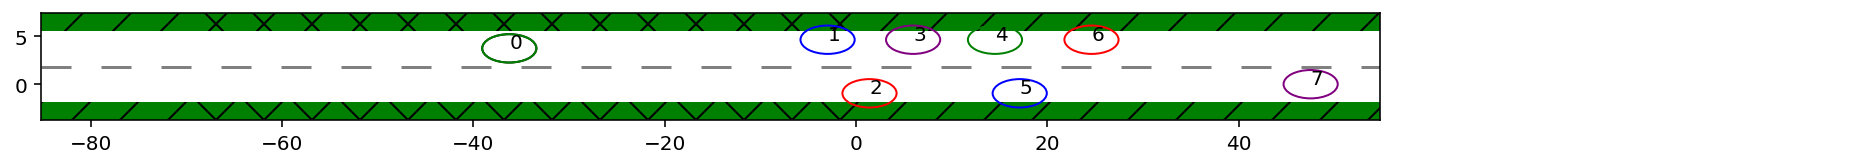

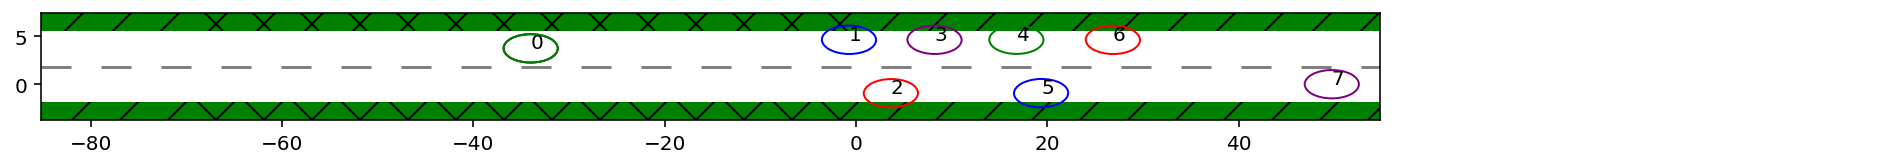

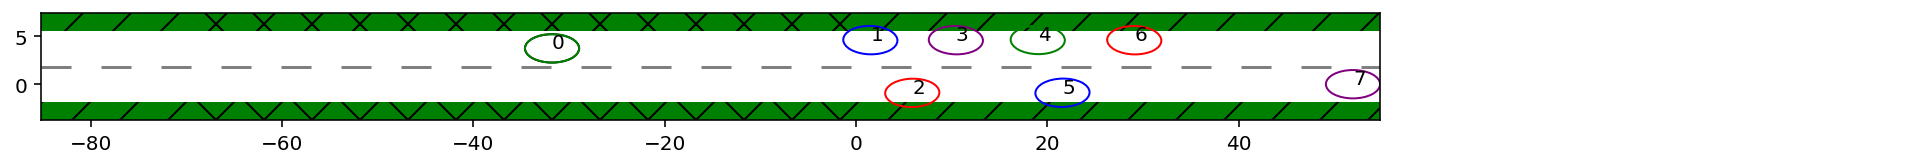

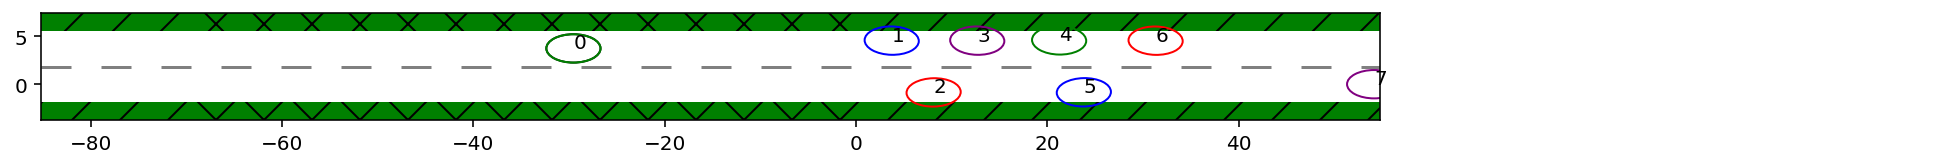

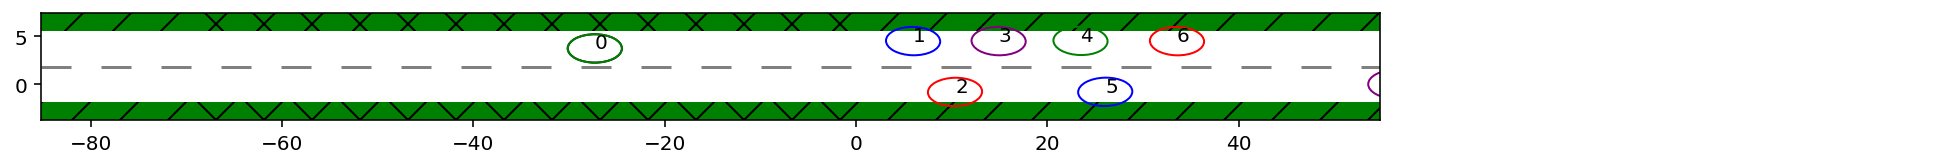

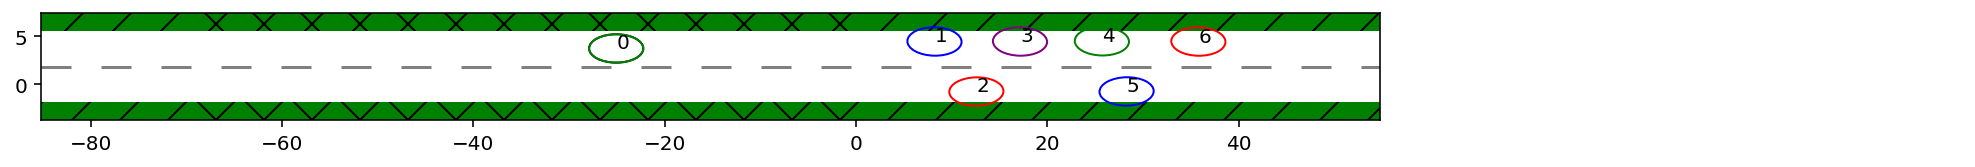

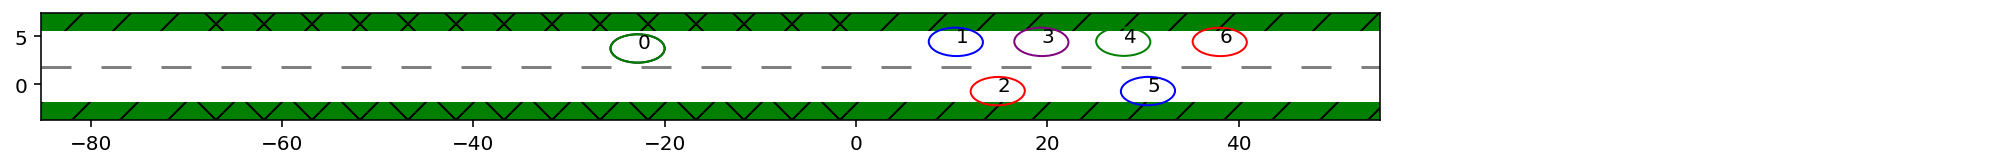

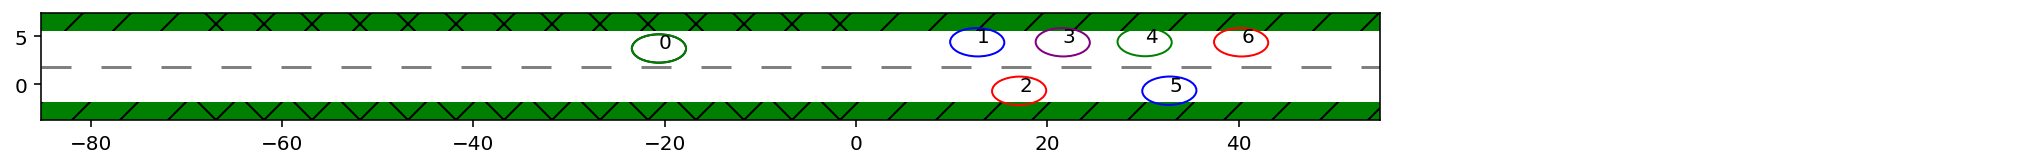

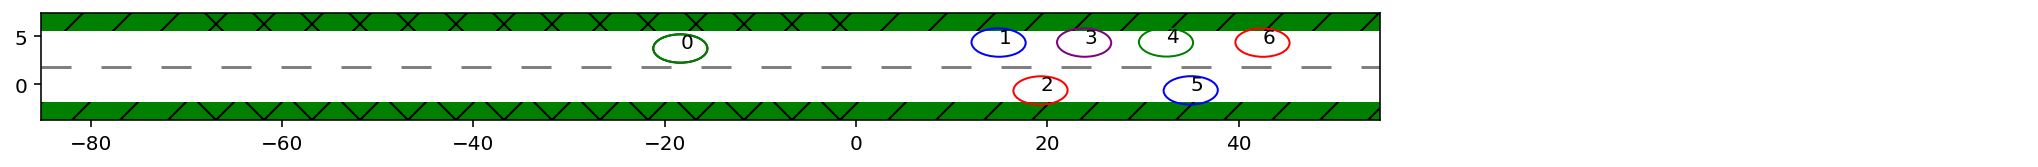

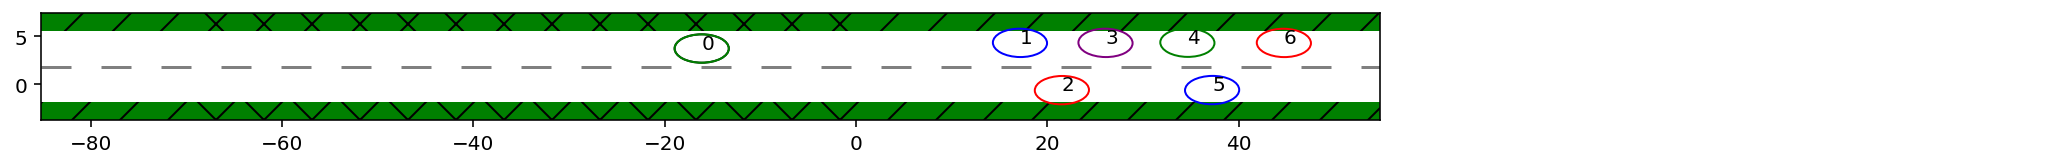

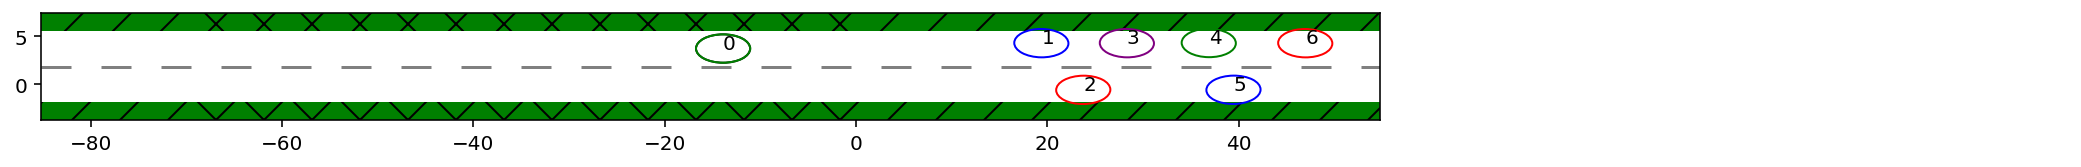

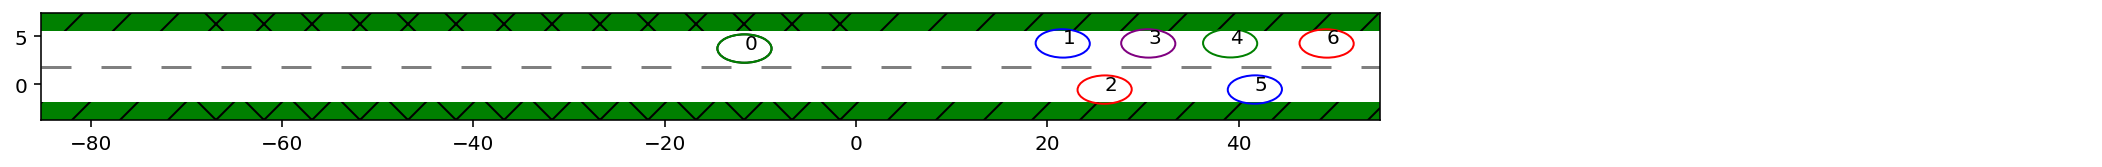

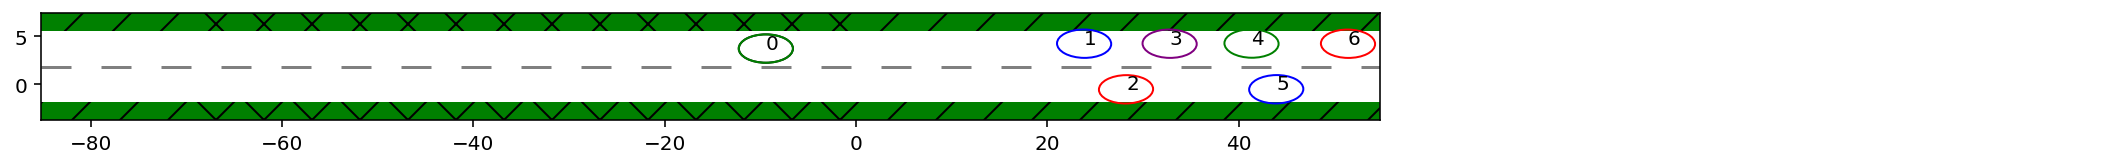

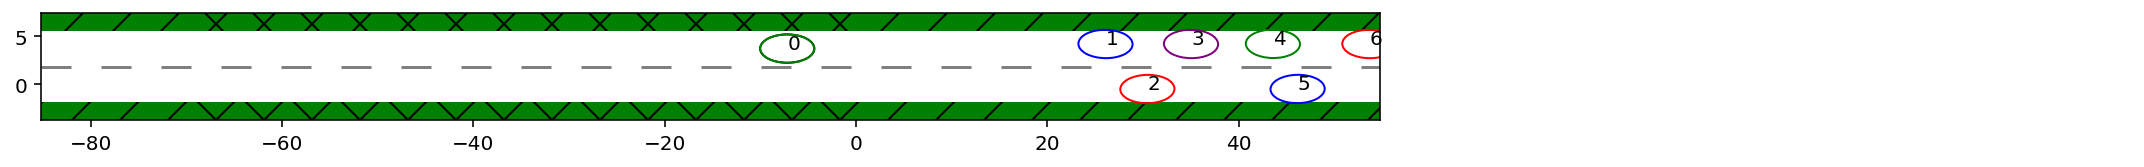

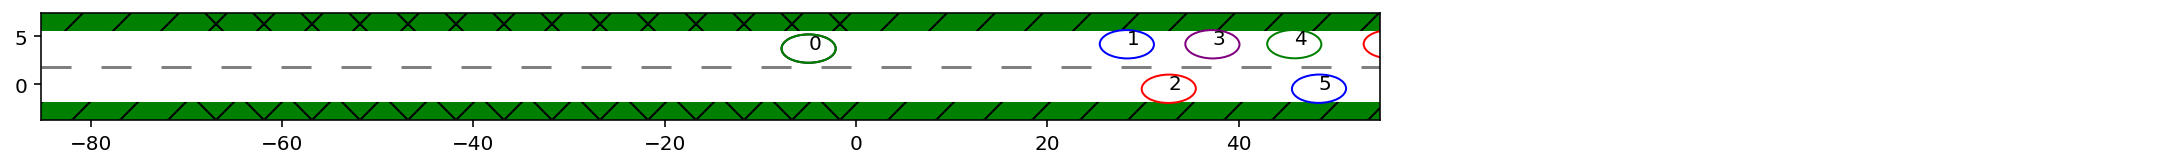

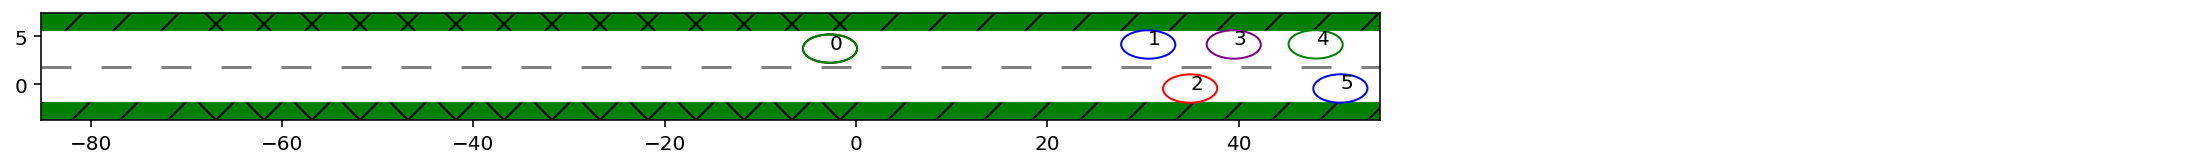

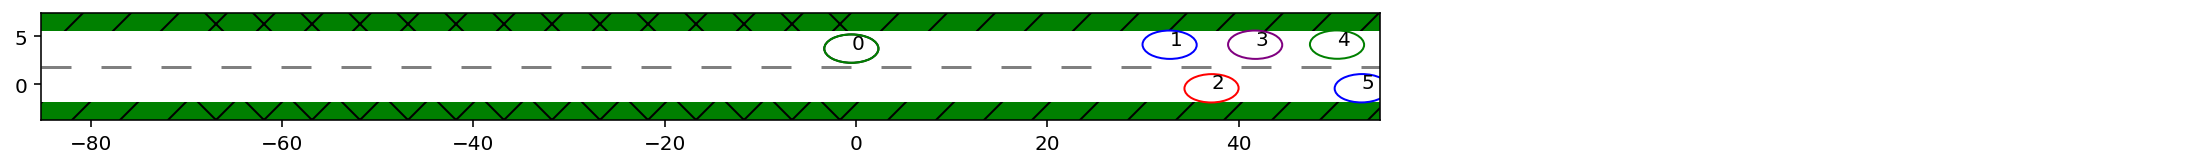

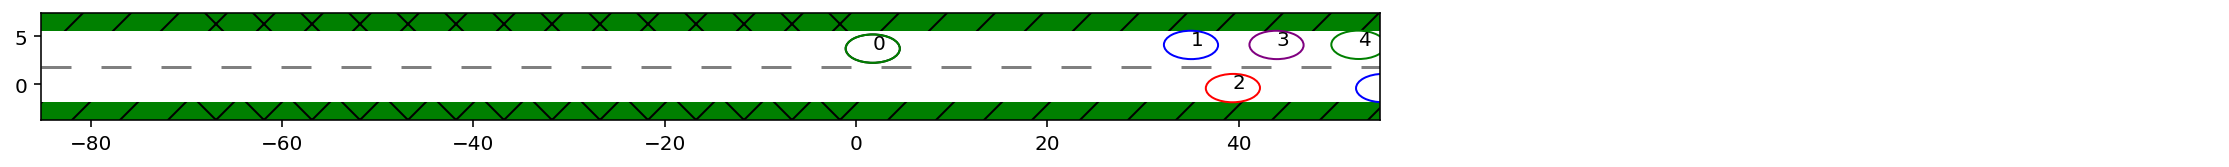

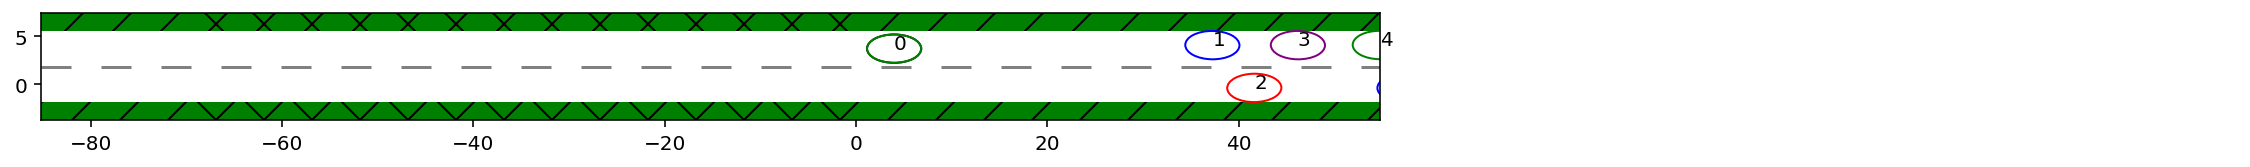

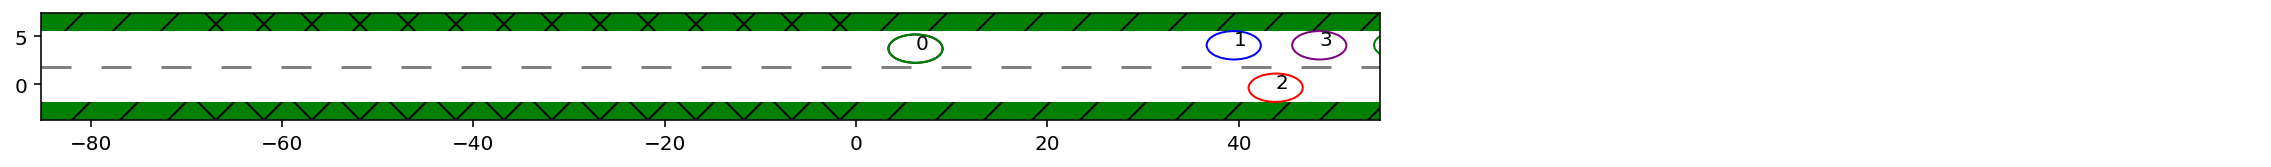

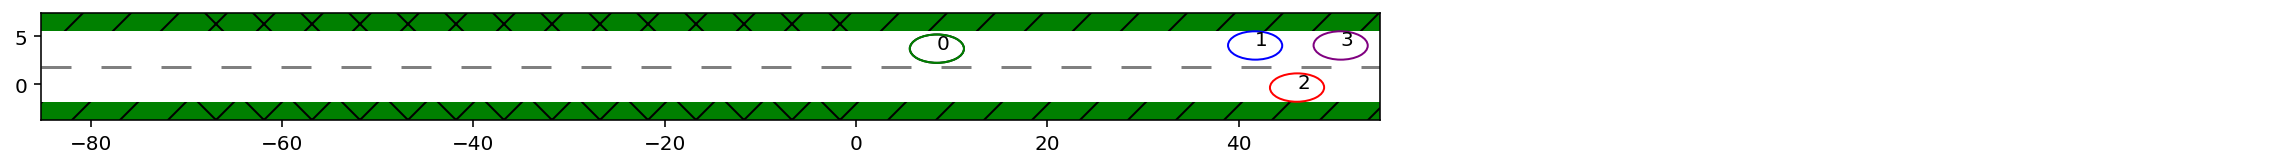

In [31]:
for k in range(params["N"]):
    cmplot.plot_single_frame(world, response_vehicle, all_other_x_ibr[0], all_other_x_ibr[:11], None, "ellipse", False, None, [k], car_ids = [-1] + [i for i in range(len(all_other_x_ibr[:11]))])

In [20]:
i_mpc = 22
i_rounds_ibr = 0
solve_number = 0
veh_id = 0
xamb_ibr, uamb_ibr, xamb_des_ibr, all_other_x_ibr, all_other_u_ibr, all_other_x_des_ibr = mpc.load_state(log_directory + "data/"+'ibr_m%03di%03da%03d'%(i_mpc, i_rounds_ibr, veh_id), params['n_other'])
for k in range(params['N']):
    cmplot.plot_single_frame(world, response_vehicle, xamb_ibr, all_other_x_ibr, None, "ellipse", False, None, [k], car_ids = [-1] + [i for i in range(len(all_other_x_ibr))])

FileNotFoundError: [Errno 2] No such file or directory: '/home/nbuckman/mpc_results/svo_10_19/p001/data/ibr_m022i000a000xamb.npy'

In [13]:
x_opt = xamb_ibr
xcntrld_opt = []
xothers_opt = all_other_x_ibr
car_length = response_vehicle.L
car_width = response_vehicle.W
min_time_to_collision = 1
N = params["N"]
for k in range(N+1):
    
    x_ego = x_opt[0, k]
    y_ego = x_opt[1, k]
    phi_ego = x_opt[2, k]
    v_ego = x_opt[4, k]
    v_ego_components = (v_ego * np.cos(phi_ego), v_ego * np.sin(phi_ego))

    for j in range(len(xcntrld_opt)):
        ## Safety constraint between ego + cntrld vehicles
        x_amb = xcntrld_opt[j][0, k]
        y_amb = xcntrld_opt[j][1, k]
        phi_amb = xcntrld_opt[j][2, k]
        v_amb = xcntrld_opt[j][4, k]    

        v_amb_components = (v_amb * np.cos(phi_amb), v_amb * np.sin(phi_amb))              

        dxegoamb = (x_amb - x_ego) - car_length
        dyegoamb = (y_amb - y_ego) - car_width
        dot_product = (v_ego_components[0] - v_amb_components[0])*dxegoamb + (v_ego_components[1] - v_amb_components[1])*dyegoamb
#         self.opti.subject_to(dot_product <= (dxegoamb**2 + dyegoamb**2) / (0.000001 + min_time_to_collision))

    for j in range(len(xothers_opt)):
        x_j = xothers_opt[j][0, k]
        y_j = xothers_opt[j][1, k]
        phi_j = xothers_opt[j][2, k]
        v_j = xothers_opt[j][4, k]       

        #### Add constraint between ego and j
        dxego = (x_j - x_ego) - car_length
        dyego = (y_j - y_ego) - car_width
        v_j_components = (v_j * np.cos(phi_j), v_j * np.sin(phi_j))
        dot_product = (v_ego_components[0] - v_j_components[0])*dxego + (v_ego_components[1] - v_j_components[1])*dyego
        if k > 20 and j == 3:
            print("LHS %.03f <= RHS %.03f"%(dot_product,(dxego**2 + dyego**2) / (0.000001 + min_time_to_collision)))
    #         self.opti.subject_to(dot_product <= (dxego**2 + dyego**2) / (0.000001 + min_time_to_collision))


LHS 1.843 <= RHS 1.867
LHS 1.255 <= RHS 1.256
LHS 0.840 <= RHS 0.839
LHS 0.551 <= RHS 0.559
LHS 0.243 <= RHS 0.393


In [27]:
k = 25
j = 3

x_ego = x_opt[0, k]
y_ego = x_opt[1, k]
phi_ego = x_opt[2, k]
v_ego = x_opt[4, k]
v_ego_components = (v_ego * np.cos(phi_ego), v_ego * np.sin(phi_ego))


x_j = xothers_opt[j][0, k]
y_j = xothers_opt[j][1, k]
phi_j = xothers_opt[j][2, k]
v_j = xothers_opt[j][4, k] - 2*response_vehicle.max_delta_u     

#### Add constraint between ego and j
dxego = (x_j - x_ego) - car_length
dyego = (y_j - y_ego) - car_width
v_j_components = (v_j * np.cos(phi_j), v_j * np.sin(phi_j))
dot_product = (v_ego_components[0] - v_j_components[0])*dxego + (v_ego_components[1] - v_j_components[1])*dyego
if k > 20 and j == 3:
    print("LHS %.03f <= RHS %.03f"%(dot_product,(dxego**2 + dyego**2) / (0.000001 + min_time_to_collision)))
#         self.opti.subject_to(dot_product <= (dxego**2 + dyego**2) / (0.000001 + min_time_to_collision))


LHS 0.426 <= RHS 0.393


In [20]:
v_ego_components[0], v_j_components[0], v_ego_components[0] - v_j_components[0]

(12.277754824556654, 11.171133539051246, 1.1066212855054083)

In [23]:
(v_ego_components[0] - v_j_components[0])*dxego, (v_ego_components[1] - v_j_components[1])*dyego, dot_product

(0.5678695112374512, -0.3244142026467449, 0.2434553085907063)

In [18]:
dxego, dyego, dxego**2 + dyego**2

(0.5131561435474268, -0.36001219685866537, 0.3929380095474697)

In [27]:
number_ctrl_pts_executed = params["number_ctrl_pts_executed"]
N = params["N"]


In [36]:
previous_all_other_u_mpc = [np.zeros((2,params["N"])) for i in range(len(all_other_MPC))]
all_other_u_ibr, all_other_x_ibr, all_other_x_des_ibr = helper.extend_last_mpc_and_follow(previous_all_other_u_mpc, params["N"]-1, N, all_other_MPC, all_other_x0, params, world)  

Ambulance guess of ado...
...veh 000
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      885
Number of nonzeros in inequality constraint Jacobian.:      180
Number of nonzeros in Lagrangian Hessian.............:      842

Total number of variables............................:      336
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      259
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:       52
   inequality constraints with lower and upper bounds:      128
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||

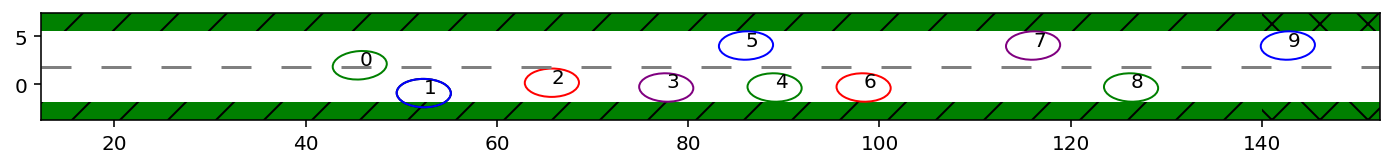

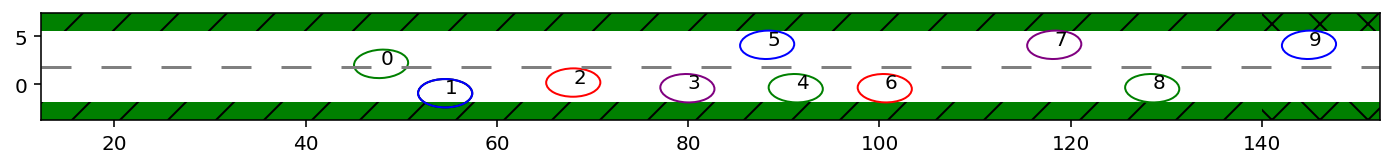

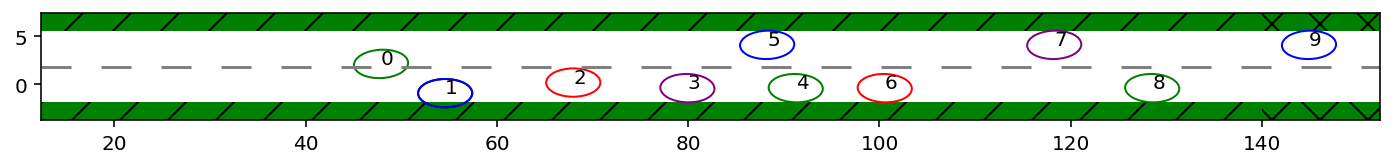

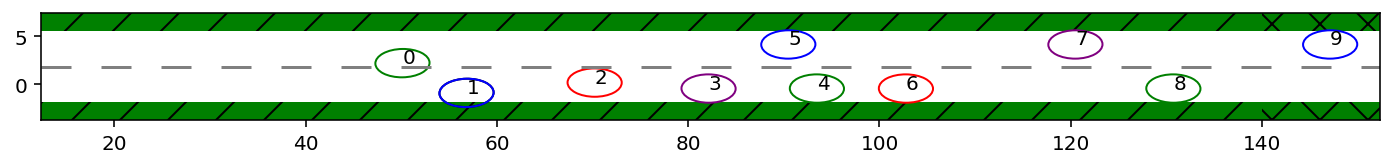

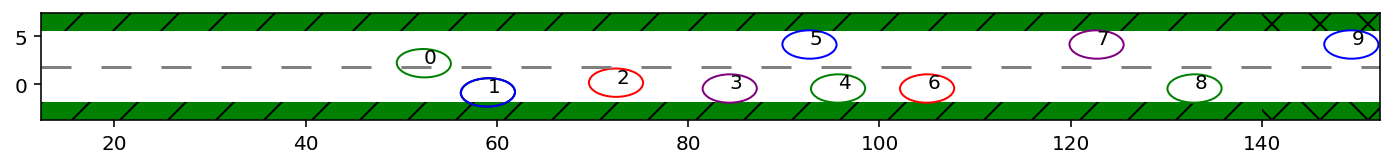

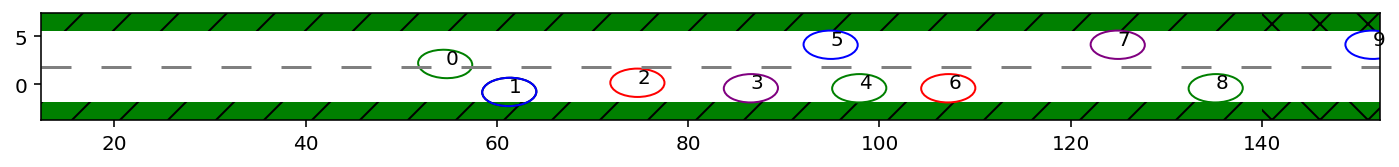

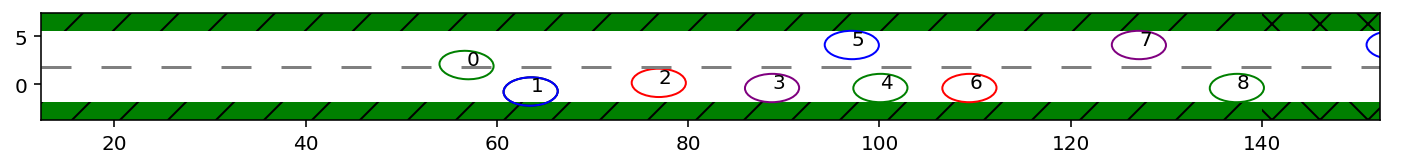

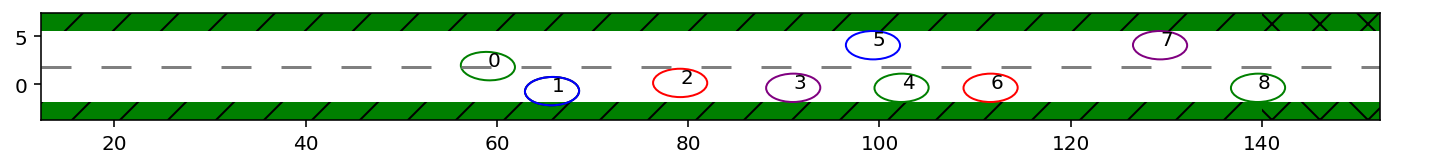

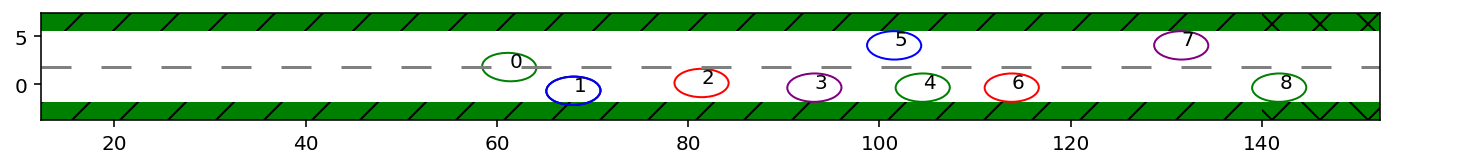

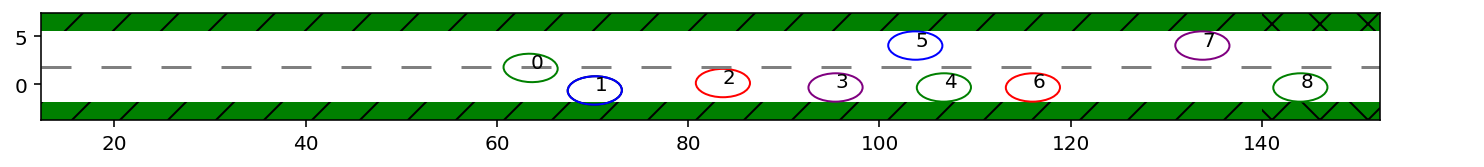

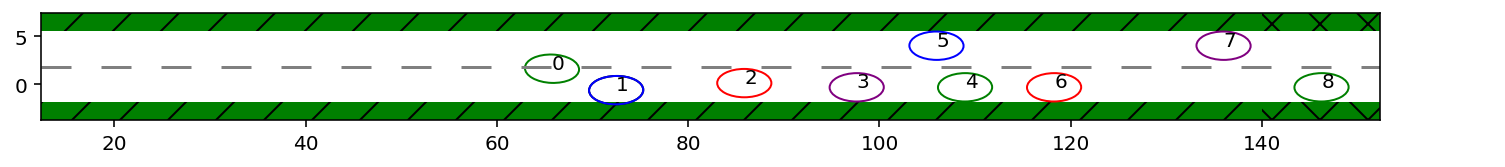

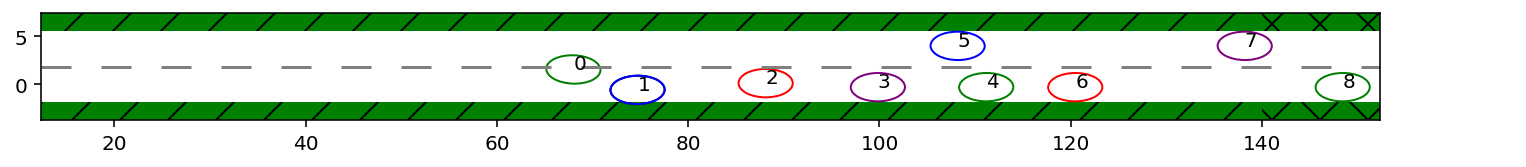

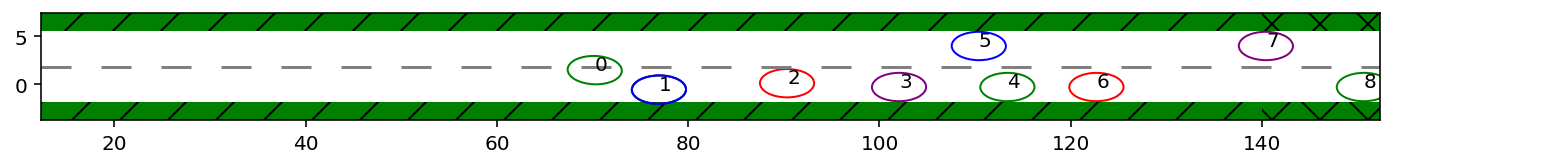

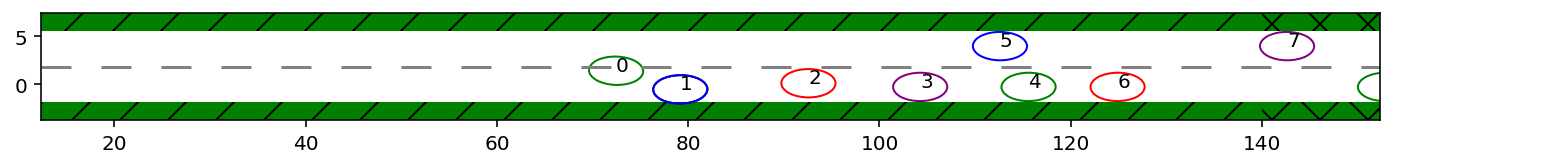

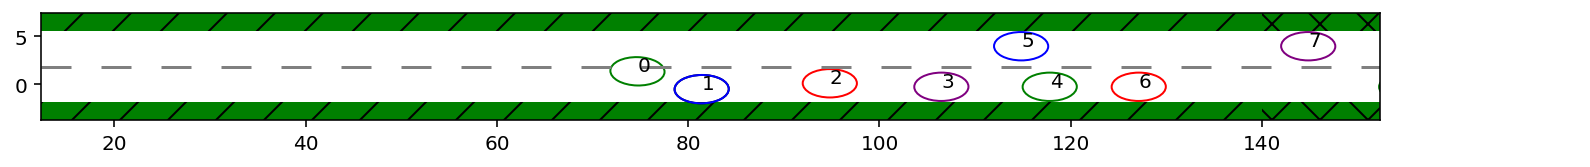

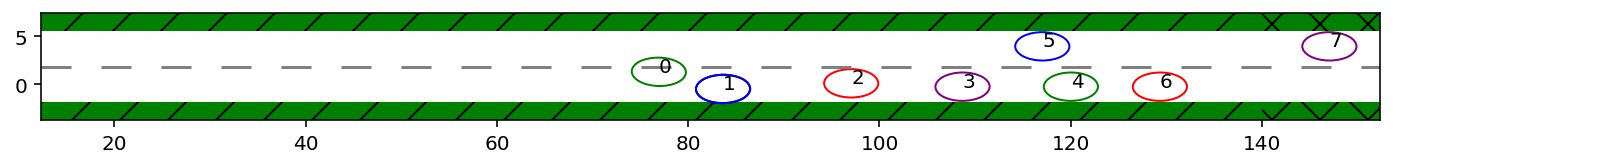

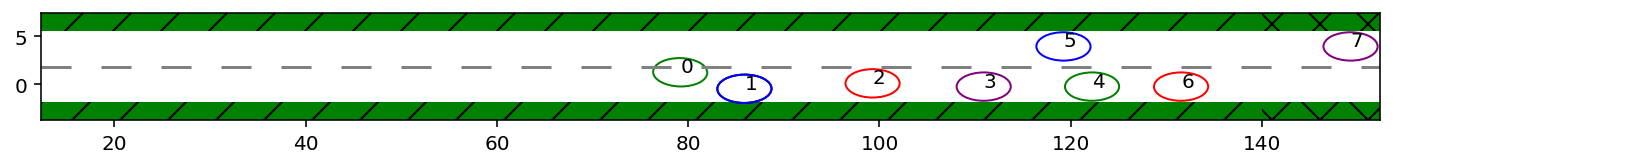

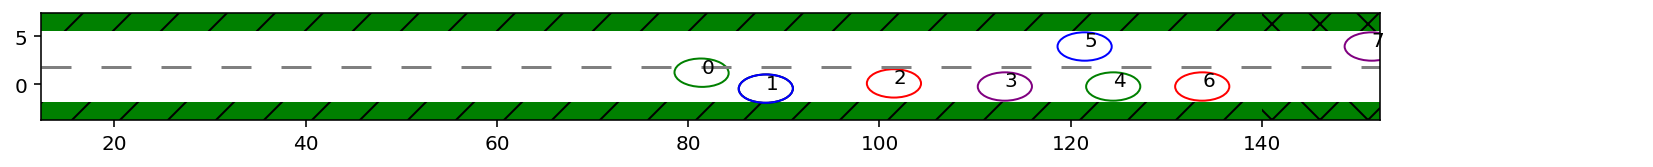

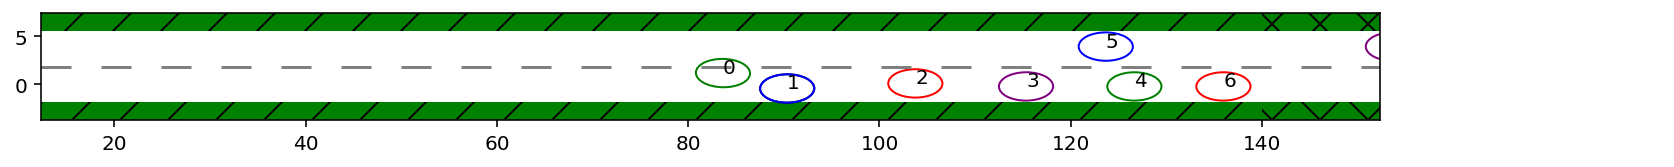

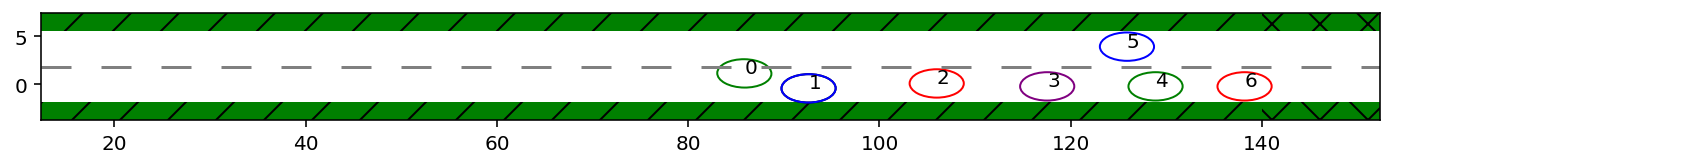

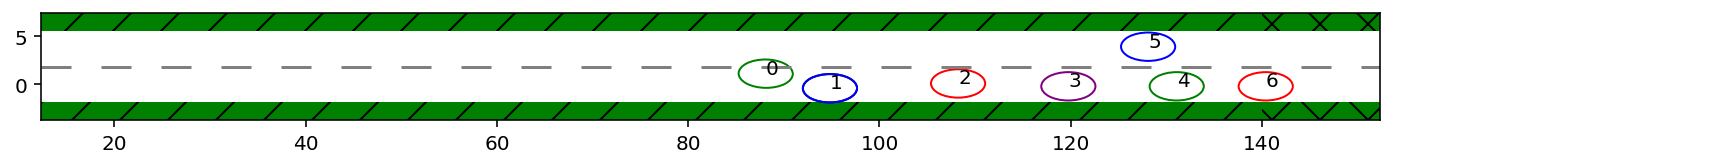

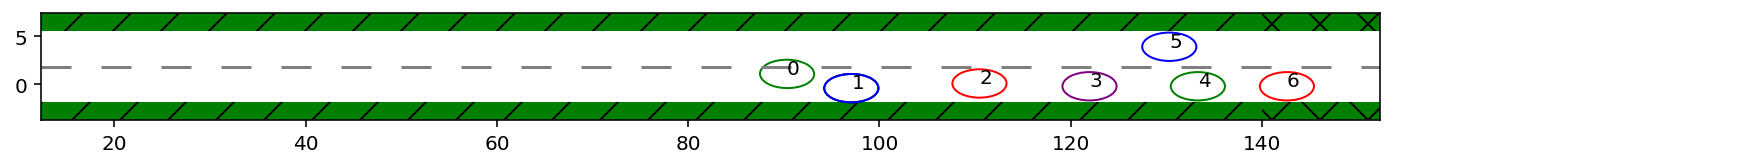

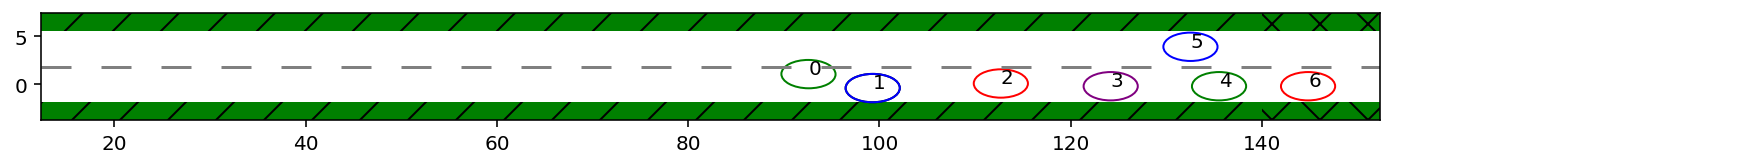

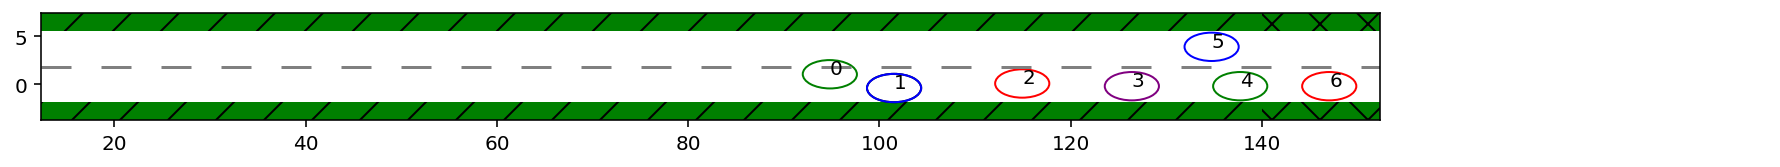

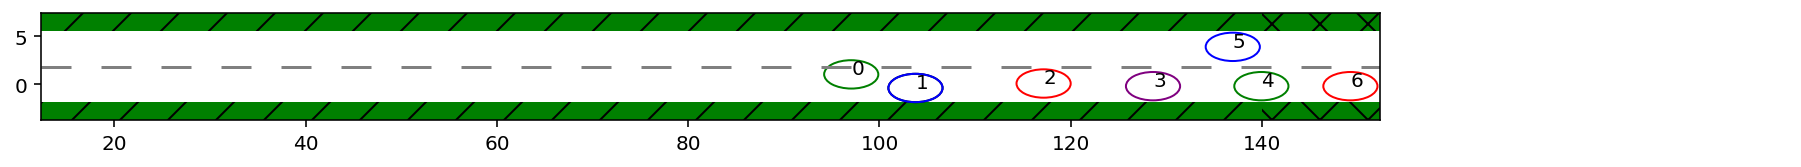

In [37]:
for k in range(params['N']):
    cmplot.plot_single_frame(world, response_vehicle, all_other_x_ibr[1], all_other_x_ibr, None, "ellipse", False, None, [k], car_ids = [-1] + [i for i in range(len(all_other_x_ibr))])

In [28]:
all_other_x0 = [x[:,params["number_ctrl_pts_executed"]] for x in all_other_x_ibr]
all_other_u_ibr, all_other_x_ibr, all_other_x_des_ibr = helper.extend_last_mpc_and_follow(all_other_u_ibr, number_ctrl_pts_executed, N, all_other_MPC, all_other_x0, params, world)  


Ambulance guess of ado...
...veh 000
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      885
Number of nonzeros in inequality constraint Jacobian.:      180
Number of nonzeros in Lagrangian Hessian.............:      842

Total number of variables............................:      336
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      259
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:       52
   inequality constraints with lower and upper bounds:      128
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:999: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'

In [30]:
i = 3
all_other_u_mpc = all_other_u_ibr

In [28]:
prev_ctrl = all_other_u_mpc[i][:, number_ctrl_pts_executed:]
prev_traj, prev_traj_des = all_other_MPC[i].forward_simulate_all(all_other_x0[i].reshape(6,1), prev_ctrl)

# Predicted portion of just lane following.  This is an estimated ctrl of ado vehicles.
initial_pt = prev_traj[:, -2]
# initial_pt[4] = 0.99*initial_pt[4]
lane_following_ctrl, lane_following_traj, lane_following_traj_des = helper.lane_following_optimizations(number_ctrl_pts_executed, all_other_MPC[i], initial_pt, params, world)

# Lane following traj's initial pt is redundant (since it is also in prev traj)
lane_following_traj = lane_following_traj[:, 1:]
lane_following_traj_des = lane_following_traj_des[:, 1:]
all_other_u_i = np.concatenate((prev_ctrl, lane_following_ctrl), axis=1)
all_other_x_i = np.concatenate((prev_traj, lane_following_traj), axis=1)
all_other_x_des_i = np.concatenate((prev_traj_des, lane_following_traj_des), axis=1)

NameError: name 'i' is not defined

In [39]:
x0

array([ 7.24965e+02,  3.72570e+00, -5.51414e-04,  8.81312e-05,
        1.11750e+01,  0.00000e+00])

In [38]:
N, response_MPC, response_x0, params, world = number_ctrl_pts_executed, all_other_MPC[i], initial_pt, params, world
x0 = cp.deepcopy(response_x0)
# x0[0] = 0.0
x0[ -1] = 0.0

cp_MPC = cp.deepcopy(response_MPC)    
bri = mpc.MultiMPC(cp_MPC, [], [], world)
bri.generate_optimization(params["N"], params["T"], x0, [], [], slack=True, solve_amb=False, params = params, ipopt_params={'print_level':5})

bri.opti.subject_to(bri.u_opt[1,:] == 0)
bri.solution = bri.opti.solve()
x, u, x_des, _, _, _, _, _, _ = bri.get_solution()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      885
Number of nonzeros in inequality constraint Jacobian.:      128
Number of nonzeros in Lagrangian Hessian.............:      842

Total number of variables............................:      284
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      259
Total number of inequality constraints...............:      128
        inequality constraints with only lower bounds:       26
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [31]:
bri.opti.debug.value(bri.u_opt)

array([[-9.53743e-04,  5.20472e-04,  4.08459e-04,  2.14125e-05,
        -7.52588e-05, -3.68028e-05, -1.15375e-05, -1.13615e-05,
        -1.45909e-05, -1.43179e-05, -1.26769e-05, -1.13572e-05,
        -1.03884e-05, -9.48598e-06, -8.57532e-06, -7.68470e-06,
        -6.82834e-06, -5.99658e-06, -5.18579e-06, -4.42781e-06,
        -3.74699e-06, -2.95539e-06, -1.58381e-06,  1.50869e-07,
        -5.18897e-05],
       [ 1.71717e-10,  6.44408e-11,  2.41829e-11,  9.07516e-12,
         3.40572e-12,  1.27816e-12,  4.79723e-13,  1.80060e-13,
         6.74969e-14,  2.52675e-14,  9.43426e-15,  3.52566e-15,
         1.35751e-15,  4.95029e-16,  1.60052e-16,  1.10456e-16,
         3.95568e-17, -2.84198e-17, -6.33075e-17,  1.88234e-18,
        -1.72556e-17, -3.49525e-17,  3.69014e-17,  2.12711e-17,
        -2.86759e-18]])

In [33]:
bri.opti.debug.value(bri.u_opt)

array([[-1.74567e-02,  4.26745e-04,  8.35449e-03,  9.76374e-03,
         7.49126e-03,  3.76305e-03,  1.41270e-04, -2.47467e-03,
        -3.76593e-03, -3.84558e-03, -3.07871e-03, -1.91084e-03,
        -7.35808e-04,  1.80620e-04,  7.21730e-04,  8.98090e-04,
         8.02132e-04,  5.58014e-04,  2.80756e-04,  5.16769e-05,
        -8.94580e-05, -1.39659e-04, -1.21181e-04, -6.86334e-05,
        -1.81851e-05],
       [-2.34223e-23,  1.82241e-19, -2.01917e-18, -7.31452e-19,
         1.21268e-18, -4.48337e-14,  1.03356e-14, -1.60772e-13,
        -4.90463e-15, -1.38498e-14, -4.31112e-16, -6.39059e-16,
        -6.52234e-25, -3.49948e-16, -4.46523e-15,  2.26417e-15,
        -5.48328e-15,  6.56889e-20,  4.62295e-20, -3.48227e-20,
        -9.75578e-21, -2.05653e-20, -1.18008e-20,  3.49248e-20,
        -1.49410e-20]])

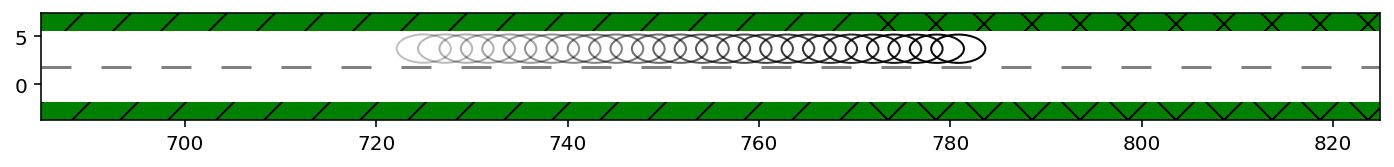

In [30]:
cmplot.plot_single_frame(world, response_vehicle, bri.opti.debug.value(bri.x_opt), [], None, "ellipse", False, None, range(bri.opti.debug.value(bri.x_opt).shape[1]))

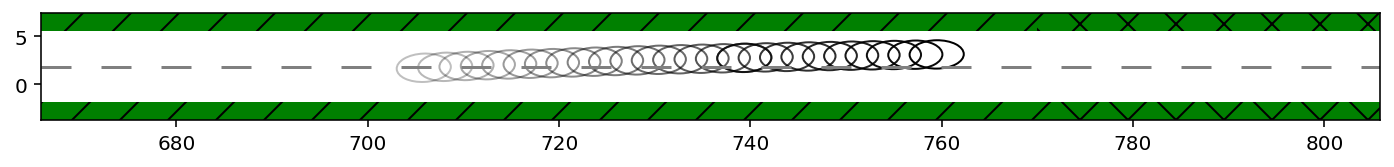

In [105]:
cmplot.plot_single_frame(world, response_vehicle, all_other_x_i, [], None, "ellipse", False, None, range(all_other_x_i.shape[1]))

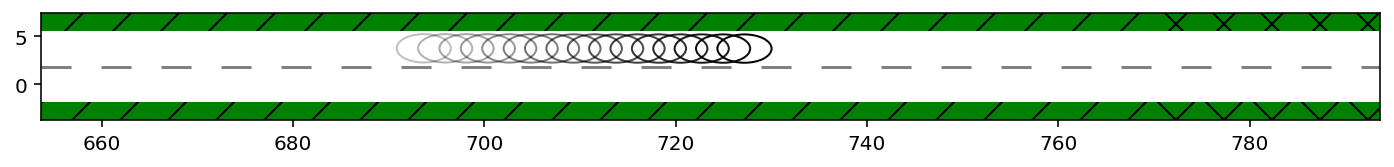

In [106]:
cmplot.plot_single_frame(world, response_vehicle, prev_traj, [], None, "ellipse", False, None, range(prev_traj.shape[1]))

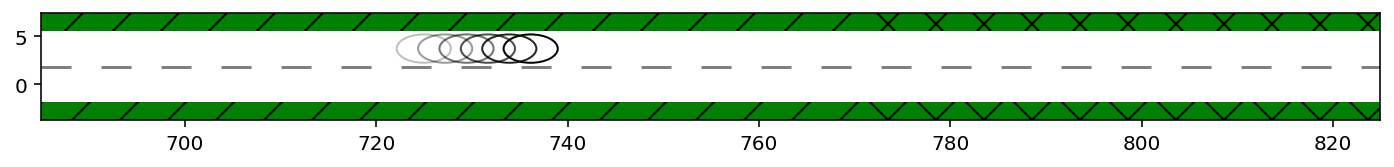

In [112]:
n_ct = 5
utest = np.zeros(shape=(2, n_ct))
# utest[0,:] = np.ones(shape=(1,n_ct)) * -response_vehicle.max_delta_u
testx, testxd = response_vehicle.forward_simulate_all(initial_pt, utest)
cmplot.plot_single_frame(world, response_vehicle, testx, [], None, "ellipse", False, None, range(testx.shape[1]))

In [18]:
bri.opti.debug.show_infeasibilities()

Violated constraints (tol 0), in order of declaration:
------- i = 0/387 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/vehicle.py:212 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At nonzero 0.
------- i = 1/387 ------ 
0 <= -4.44089e-16 <= 0 (viol 4.44089e-16)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/vehicle.py:212 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At nonzero 1.
------- i = 2/387 ------ 
0 <= -4.18068e-16 <= 0 (viol 4.18068e-16)
Opti constraint of shape 6x1, defined at /home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/src/vehicle.py:212 in add_dynamics_constraints
  opti.subject_to( X[:, k+1] == self.F_kutta(self.f, X[:, k], U[:, k]))
At nonzero 2.
---

In [69]:
bri.opti.debug.value(bri.x_opt)

array([[ 7.52670e+02,  7.54882e+02,  7.57094e+02],
       [ 4.51410e+00,  4.58114e+00,  4.65000e+00],
       [ 2.41714e-02,  3.35761e-02,  2.58137e-02],
       [ 3.65760e-02,  1.66938e-03, -3.32372e-02],
       [ 1.10633e+01,  1.10633e+01,  1.10633e+01],
       [ 6.74267e+02,  6.76479e+02,  6.78692e+02]])

In [70]:
x_test = bri.opti.debug.value(bri.x_opt)
for k in range(x_test.shape[1]):
    print(
        -1,
        "< X %0.03f<"%x_test[0,k],
        np.infty,
        )

    print("%.03f < Y %0.03f< %0.03f"%(
        all_other_MPC[i].min_y + all_other_MPC[i].W/2.0, 
        x_test[1,k],
        all_other_MPC[i].max_y - all_other_MPC[i].W/2.0,
        )
         )

    print("%.03f < Phi %0.03f< %0.03f"%(
        -np.pi/2.0, 
        x_test[2,k],
        np.pi/2.0,
        )
         )

    print("%.03f < V %0.03f< %0.03f"%(
        all_other_MPC[i].min_v, 
        x_test[4,k],
        all_other_MPC[i].max_v,
        )
         )



-1 < X 752.670< inf
-0.950 < Y 4.514< 4.650
-1.571 < Phi 0.024< 1.571
0.000 < V 11.063< 11.175
-1 < X 754.882< inf
-0.950 < Y 4.581< 4.650
-1.571 < Phi 0.034< 1.571
0.000 < V 11.063< 11.175
-1 < X 757.094< inf
-0.950 < Y 4.650< 4.650
-1.571 < Phi 0.026< 1.571
0.000 < V 11.063< 11.175


In [71]:
print(
    -1,
    "< X %0.03f<"%initial_pt[0],
    np.infty,
    )

print("%.03f < Y %0.03f< %0.03f"%(
    all_other_MPC[i].min_y + all_other_MPC[i].W/2.0, 
    initial_pt[1],
    all_other_MPC[i].max_y - all_other_MPC[i].W/2.0,
    )
     )

print("%.03f < Phi %0.03f< %0.03f"%(
    -np.pi/2.0, 
    initial_pt[2],
    np.pi/2.0,
    )
     )

print("%.03f < V %0.03f< %0.03f"%(
    all_other_MPC[i].min_v, 
    initial_pt[4],
    all_other_MPC[i].max_v,
    )
     )



-1 < X 752.670< inf
-0.950 < Y 4.514< 4.650
-1.571 < Phi 0.047< 1.571
0.000 < V 11.063< 11.175


In [50]:
print(initial_pt)

[7.52670e+02 4.51410e+00 4.69361e-02 3.65760e-02 1.11750e+01 6.74267e+02]


## Investigate the MPC Failure

- First load everything up to and util solver_warm_starts.  Observe the setup (visualize)
- Look at the warm starts
- Solve?

In [ ]:
i_mpc = 47
veh_id = -1
i_rounds_ibr = 0
solve_number = 0

In [ ]:
if veh_id < 0: #ambulance
    with open(log_directory + 'data/inputs_amb_mpc_%02d_ibr_%d_s_%d.p'%(i_mpc, i_rounds_ibr, solve_number),'rb') as fp:
        solver_inputs = pickle.load(fp)
else:
    with open(log_directory + 'data/inputs_v%02d_mpc_%03d_ibr_%d_s_%d.p'%(veh_id, i_mpc, i_rounds_ibr, solve_number),'rb') as fp:
        solver_inputs = pickle.load(fp)
ux_warm_profiles_subset, response_vehicle, amb_vehicle, nonresponse_vehicle_list,response_x0, amb_x0, nonresponse_x0_list, world, solver_params, params, nonresponse_u_list, nonresponse_x_list, nonresponse_xd_list, amb_u, amb_x, amb_xd, debug_flag = solver_inputs


### Plot Ambulance Conditions

In [ ]:
# Reshape the initial_list
cmplot.plot_single_frame(world, response_vehicle, response_x0.reshape(6,1), [x0.reshape(6,1) for x0 in nonresponse_x0_list + [amb_x0] if x0 is not None], None, "ellipse", False, None)

### Plot Ado Conditions

In [ ]:
i_mpc = 47
veh_id = -1
i_rounds_ibr = 0
solve_number = 0

if veh_id < 0: #ambulance
    with open(log_directory + 'data/inputs_amb_mpc_%02d_ibr_%d_s_%d.p'%(i_mpc, i_rounds_ibr, solve_number),'rb') as fp:
        solver_inputs = pickle.load(fp)
else:
    with open(log_directory + 'data/inputs_v%02d_mpc_%03d_ibr_%d_s_%d.p'%(veh_id, i_mpc, i_rounds_ibr, solve_number),'rb') as fp:
        solver_inputs = pickle.load(fp)
ux_warm_profiles_subset, response_MPC, amb_MPC, nonresponse_MPC_list,response_x0, amb_x0, nonresponse_x0_list, world, solver_params, params, nonresponse_u_list, nonresponse_x_list, nonresponse_xd_list, amb_u, amb_x, amb_xd, debug_flag = solver_inputs


In [ ]:
# Reshape the initial_list
cmplot.plot_single_frame(world, response_vehicle, response_x0.reshape(6,1), [x0.reshape(6,1) for x0 in nonresponse_x0_list + [amb_x0] if x0 is not None], None, "ellipse", False, None)

### Plot Warm Start

In [ ]:
for warm_key in ux_warm_profiles_subset:
    u, x_w, x_des = ux_warm_profiles_subset[warm_key]
    print(warm_key)
    for k in [params["N"]]:
        cmplot.plot_single_frame(world, response_MPC, x_w, [x for x in nonresponse_x_list], None, "ellipse", False, None, [0, 5, 10, 15, 20])    
    print(" \n \n")

### Let's Try Solving An Easy Solution

In [ ]:
warm_key = '0constant v'
u, x_w, x_des = ux_warm_profiles_subset[warm_key]
for k in range(params["N"] - number_ctrl_pts_executed + 10):
    cmplot.plot_single_frame(world, response_MPC, x_w, [x for x in nonresponse_x_list], None, "ellipse", False, None, [k])    

#### Solve for all the warm starts

In [ ]:
solved, current_cost, max_slack, x_ibr, x_des_ibr, u_ibr, warm_key, debug_list = helper.solve_warm_starts(ux_warm_profiles_subset, response_MPC, amb_MPC, nonresponse_MPC_list,response_x0, amb_x0, nonresponse_x0_list, world, solver_params, params, nonresponse_u_list, nonresponse_x_list, nonresponse_xd_list, amb_u, amb_x, amb_xd, True)

In [ ]:
for k in range(params["N"]):
    cmplot.plot_single_frame(world, response_MPC, x_ibr, [x for x in nonresponse_x_list] + [amb_x], None, "ellipse", False, None, [k])    

In [ ]:
i_mpc = 19
veh_id = 1
i_rounds_ibr = 0
solve_number = 0

if veh_id < 0: #ambulance
    with open(log_directory + 'data/inputs_amb_mpc_%02d_ibr_%d_s_%d.p'%(i_mpc, i_rounds_ibr, solve_number),'rb') as fp:
        solver_inputs = pickle.load(fp)
else:
    with open(log_directory + 'data/inputs_v%02d_mpc_%03d_ibr_%d_s_%d.p'%(veh_id, i_mpc, i_rounds_ibr, solve_number),'rb') as fp:
        solver_inputs = pickle.load(fp)
ux_warm_profiles_subset, response_MPC, amb_MPC, nonresponse_MPC_list,response_x0, amb_x0, nonresponse_x0_list, world, solver_params, params, nonresponse_u_list, nonresponse_x_list, nonresponse_xd_list, amb_u, amb_x, amb_xd, debug_flag = solver_inputs


In [ ]:
warm_key = 'none none'
u, x_w, x_des = ux_warm_profiles_subset[warm_key]
for k in range(params["N"]):
    cmplot.plot_single_frame(world, response_MPC, x_w, [x for x in nonresponse_x_list] + [amb_x], None, "ellipse", False, None, [k])    

In [ ]:
i_mpc = 19
veh_id = 1
i_rounds_ibr = 1
solve_number = 0

if veh_id < 0: #ambulance
    with open(log_directory + 'data/inputs_amb_mpc_%02d_ibr_%d_s_%d.p'%(i_mpc, i_rounds_ibr, solve_number),'rb') as fp:
        solver_inputs = pickle.load(fp)
else:
    with open(log_directory + 'data/inputs_v%02d_mpc_%03d_ibr_%d_s_%d.p'%(veh_id, i_mpc, i_rounds_ibr, solve_number),'rb') as fp:
        solver_inputs = pickle.load(fp)
ux_warm_profiles_subset, response_MPC, amb_MPC, nonresponse_MPC_list,response_x0, amb_x0, nonresponse_x0_list, world, solver_params, params, nonresponse_u_list, nonresponse_x_list, nonresponse_xd_list, amb_u, amb_x, amb_xd, debug_flag = solver_inputs


warm_key = 'none none'
u, x_w, x_des = ux_warm_profiles_subset[warm_key]
for k in range(params["N"]):
    cmplot.plot_single_frame(world, response_MPC, x_w, [x for x in nonresponse_x_list] + [amb_x], None, "ellipse", False, None, [k])    

In [ ]:
i_mpc = 19
veh_id = 0
i_rounds_ibr = 2
solve_number = 0

if veh_id < 0: #ambulance
    with open(log_directory + 'data/inputs_amb_mpc_%02d_ibr_%d_s_%d.p'%(i_mpc, i_rounds_ibr, solve_number),'rb') as fp:
        solver_inputs = pickle.load(fp)
else:
    with open(log_directory + 'data/inputs_v%02d_mpc_%03d_ibr_%d_s_%d.p'%(veh_id, i_mpc, i_rounds_ibr, solve_number),'rb') as fp:
        solver_inputs = pickle.load(fp)
ux_warm_profiles_subset, response_MPC, amb_MPC, nonresponse_MPC_list,response_x0, amb_x0, nonresponse_x0_list, world, solver_params, params, nonresponse_u_list, nonresponse_x_list, nonresponse_xd_list, amb_u, amb_x, amb_xd, debug_flag = solver_inputs


warm_key = 'none none'
u, x_w, x_des = ux_warm_profiles_subset[warm_key]
for k in range(params["N"]):
    cmplot.plot_single_frame(world, response_MPC, x_w, [x for x in nonresponse_x_list] + [amb_x], None, "ellipse", False, None, [k])    

In [ ]:
i_mpc = 19
veh_id = 1
i_rounds_ibr = 2
solve_number = 0

if veh_id < 0: #ambulance
    with open(log_directory + 'data/inputs_amb_mpc_%02d_ibr_%d_s_%d.p'%(i_mpc, i_rounds_ibr, solve_number),'rb') as fp:
        solver_inputs = pickle.load(fp)
else:
    with open(log_directory + 'data/inputs_v%02d_mpc_%03d_ibr_%d_s_%d.p'%(veh_id, i_mpc, i_rounds_ibr, solve_number),'rb') as fp:
        solver_inputs = pickle.load(fp)
ux_warm_profiles_subset, response_MPC, amb_MPC, nonresponse_MPC_list,response_x0, amb_x0, nonresponse_x0_list, world, solver_params, params, nonresponse_u_list, nonresponse_x_list, nonresponse_xd_list, amb_u, amb_x, amb_xd, debug_flag = solver_inputs


warm_key = 'none none'
u, x_w, x_des = ux_warm_profiles_subset[warm_key]
for k in range(params["N"]):
    cmplot.plot_single_frame(world, response_MPC, x_w, [x for x in nonresponse_x_list] + [amb_x], None, "ellipse", False, None, [k])    

## Plot the debug solution

In [ ]:
bri = solution[-1]

In [ ]:
x_debug = bri.opti.debug.value(bri.x_opt)
xother_debug = [bri.opti.debug.value(x) for x in bri.allother_x_opt]

In [ ]:
for k in range(params["N"]):
    cmplot.plot_single_frame(world, response_MPC, x_debug, xother_debug, None, "ellipse", False, None, [k])    

In [ ]:
x_initial = bri.opti.debug.value(bri.x_opt, bri.opti.initial())

In [ ]:
for k in range(params["N"]):
    cmplot.plot_single_frame(world, response_MPC, x_debug, [x_initial], None, "ellipse", False, None, [k])    

In [ ]:
bri.opti.debug.show_infeasibilities()